# 01 Data Cleaning




Phase 0:

Phase 1	
	1.	Compute within / between variance of ND-GAIN at annual frequency (total, between, within, share within). Save a small table and histogram of year-to-year changes (diff1) and report per-country within SD.
	2.	Count how many countries and how many country-years show substantive ND-GAIN change; identify outliers (big diffs).
	3.	Compute per-country summary (mean, SD, number of years). Produce a short paragraph interpreting whether FE is likely to be feasible.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/Users/leosgambato/Documents/GitHub/Capstone/data/processed/baseline_with_gain.csv')

# Clean up: drop rows where 'gain' is missing or iso3c is missing
df = df.dropna(subset=['gain', 'iso3c','sovereign_spread'])

# 1. Compute within / between variance of Gain at annual frequency

# Compute overall mean
overall_mean = df['gain'].mean()

# Compute per-country mean
country_means = df.groupby('iso3c')['gain'].mean()

# Merge country means back to df
df = df.merge(country_means.rename('country_mean'), left_on='iso3c', right_index=True)

# Between variance: variance of country means
between_var = country_means.var(ddof=0)

# Within variance: mean of per-country variances
within_var = df.groupby('iso3c')['gain'].var(ddof=0).mean()

# Total variance
total_var = df['gain'].var(ddof=0)

# Share within
share_within = within_var / total_var if total_var > 0 else np.nan

print("Variance decomposition of ND-GAIN (annual):")
print(f"  Total variance:   {total_var:.4f}")
print(f"  Between variance: {between_var:.4f}")
print(f"  Within variance:  {within_var:.4f}")
print(f"  Share within:     {share_within:.2%}")

# 2. Histogram and table of year-to-year changes (diff1), per-country within SD

# Sort for diff calculation
df = df.sort_values(['iso3c', 'year'])

# Compute year-to-year difference
df['gain_diff1'] = df.groupby('iso3c')['gain'].diff()

# Table of year-to-year changes (drop NA)
diff1_table = df[['iso3c', 'year', 'gain_diff1']].dropna()

# Save small table (first 10 rows as example)
diff1_table.head(10).to_csv('/Users/leosgambato/Documents/GitHub/Capstone/outputs/gain_diff1_sample.csv', index=False)

# Histogram of all year-to-year changes
plt.figure(figsize=(8,5))
plt.hist(diff1_table['gain_diff1'], bins=30, edgecolor='k')
plt.title('Histogram of Year-to-Year Changes in ND-GAIN')
plt.xlabel('Year-to-Year Change (diff1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('/Users/leosgambato/Documents/GitHub/Capstone/outputs/gain_diff1_hist.png')
plt.close()

# Per-country within SD
country_within_sd = df.groupby('iso3c')['gain'].std().rename('within_sd')
country_within_sd = country_within_sd.reset_index()
country_within_sd.head(10).to_csv('/Users/leosgambato/Documents/GitHub/Capstone/outputs/gain_within_sd_sample.csv', index=False)

# 2. Count countries and country-years with substantive ND-GAIN change; identify outliers

# Define substantive change threshold (e.g., > 1 SD of all diffs)
diff1_sd = diff1_table['gain_diff1'].std()
substantive_thresh = diff1_sd

# Count country-years with |diff1| > threshold
substantive_changes = diff1_table[np.abs(diff1_table['gain_diff1']) > substantive_thresh]
n_substantive = len(substantive_changes)
n_countries = substantive_changes['iso3c'].nunique()

print(f"\nNumber of country-years with substantive ND-GAIN change (>|{substantive_thresh:.2f}|): {n_substantive}")
print(f"Number of countries with at least one substantive change: {n_countries}")

# Identify outliers (e.g., top 5 biggest absolute diffs)
outliers = diff1_table.reindex(diff1_table['gain_diff1'].abs().sort_values(ascending=False).index).head(5)
print("\nTop 5 outlier year-to-year changes in ND-GAIN:")
print(outliers)

# 3. Per-country summary (mean, SD, number of years)
country_summary = df.groupby('iso3c').agg(
    mean_gain=('gain', 'mean'),
    sd_gain=('gain', 'std'),
    n_years=('gain', 'count')
).reset_index()

country_summary.head(10).to_csv('/Users/leosgambato/Documents/GitHub/Capstone/outputs/gain_country_summary_sample.csv', index=False)

# Short paragraph interpreting FE feasibility
print("\nInterpretation:")
print("The variance decomposition shows that a substantial share of the total variance in ND-GAIN is due to between-country differences, with within-country (over time) variance being relatively smaller. The per-country within SDs are generally low, and only a small number of country-years show substantive changes in ND-GAIN from year to year. This suggests that country fixed effects (FE) models may be feasible, but the limited within-country variation could reduce the power to detect effects of time-varying covariates. Outlier years with large changes should be checked for data quality or exceptional events.")


Variance decomposition of ND-GAIN (annual):
  Total variance:   116.0202
  Between variance: 114.1825
  Within variance:  4.5763
  Share within:     3.94%

Number of country-years with substantive ND-GAIN change (>|0.98|): 178
Number of countries with at least one substantive change: 57

Top 5 outlier year-to-year changes in ND-GAIN:
     iso3c  year  gain_diff1
2228   BGD  2014  -11.062157
2274   NGA  2014  -10.871986
2256   IND  2014   -9.909187
2278   PAK  2014   -8.339038
2270   MEX  2014   -7.692216

Interpretation:
The variance decomposition shows that a substantial share of the total variance in ND-GAIN is due to between-country differences, with within-country (over time) variance being relatively smaller. The per-country within SDs are generally low, and only a small number of country-years show substantive changes in ND-GAIN from year to year. This suggests that country fixed effects (FE) models may be feasible, but the limited within-country variation could reduce the power 

### Data cleaning, Exploratory analysis, creating lags etc. 


In [69]:
# Check for any remaining missing values
print(f"\nMissing values summary:")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("No missing values in the dataset")

print("\nDataset ready for analysis!")



Missing values summary:
cpi_yoy                   267
wgi_cc                    144
wgi_ge                    144
wgi_pv                    144
wgi_rl                    144
wgi_rq                    144
wgi_va                    144
gain_diff1                 67
gdp_annual_growth_rate     66
debt_to_gdp                11
dtype: int64

Dataset ready for analysis!


In [70]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [71]:
# ensure year is integer
df['year'] = df['year'].astype(int)
df = df.sort_values(['iso3c','year']).reset_index(drop=True)

In [72]:
# Log transforms (avoid log(0) by replacing zeros with tiny positive number)
df['ln_gdp_per_capita'] = np.log(df['gdp_per_capita'].replace(0, np.nan))
df['ln_gross_gdp'] = np.log(df['gross gdp'].replace(0, np.nan))

# If you prefer to drop the raw gross_gdp or gdp_per_capita from covariates, decide later

In [73]:
def create_lags(df, group='iso3c', time='year', variables=None, lags=(1,2)):
    """
    Add lagged versions of `variables` grouped by `group` and sorted by `time`.
    variables: list of column names
    lags: tuple/list of lag integers e.g. (1,2)
    """
    df = df.sort_values([group, time]).copy()
    for var in variables:
        for lag in lags:
            new_col = f"{var}_lag{lag}"
            df[new_col] = df.groupby(group)[var].shift(lag)
    return df

# Variables we recommend lagging (one or two lags)
vars_to_lag = [
    'sovereign_spread',    # outcome lag Y_lag1
    'cpi_yoy',
    'gdp_annual_growth_rate',
    'ln_gdp_per_capita',
    'ln_gross_gdp',
    'debt_to_gdp',
    'deficit_to_gdp',
    'current_account_balance',
    # Add global factors if present (VIX, US10y, Brent)
    # 'VIX', 'US10y', 'Brent'
]

# add lag1 and lag2 (you can restrict to only lag1 by passing lags=(1,))
df = create_lags(df, group='iso3c', time='year', variables=vars_to_lag, lags=(1,2))

In [74]:
# ND-GAIN is 'gain' column
df = df.sort_values(['iso3c','year']).reset_index(drop=True)
df['gain_diff1'] = df.groupby('iso3c')['gain'].diff(1)
df['gain_diff3'] = df.groupby('iso3c')['gain'].diff(3)
df['gain_diff5'] = df.groupby('iso3c')['gain'].diff(5)

# outlier threshold (you used 0.91 earlier; keep parametric)
OUTLIER_THRESHOLD = 0.91
df['gain_substantive_change'] = df['gain_diff1'].abs() > OUTLIER_THRESHOLD

# list top K absolute diffs for quick inspection
def top_gain_changes(df, k=10):
    tmp = df[['iso3c','year','gain_diff1']].dropna().assign(absdiff= df['gain_diff1'].abs())
    return tmp.sort_values('absdiff', ascending=False).head(k)

# winsorize function
def winsorize_ser(s, lower_pct=0.01, upper_pct=0.99):
    lo = s.quantile(lower_pct)
    hi = s.quantile(upper_pct)
    return s.clip(lower=lo, upper=hi)

# Example: create winsorized diff for diagnostics (do not replace original unless you choose)
df['gain_diff1_wins'] = winsorize_ser(df['gain_diff1'], 0.01, 0.99)

#### 5) Imputation flags (per variable) — create columns marking missingness

In [75]:
# choose list of candidate covariates we'll eventually impute (lagged and level vars)
candidate_covs = [
    # lagged covariates
    'sovereign_spread_lag1', 'sovereign_spread_lag2',
    'cpi_yoy_lag1', 'cpi_yoy_lag2',
    'gdp_annual_growth_rate_lag1', 'gdp_annual_growth_rate_lag2',
    'ln_gdp_per_capita_lag1', 'ln_gdp_per_capita_lag2',
    'debt_to_gdp_lag1', 'debt_to_gdp_lag2',
    'deficit_to_gdp_lag1', 'deficit_to_gdp_lag2',
    'current_account_balance_lag1', 'current_account_balance_lag2',
    # governance (we treat as slow-moving; missing flags still useful)
    'wgi_cc','wgi_ge','wgi_pv','wgi_rl','wgi_rq','wgi_va',
    # treatment (do not impute treatment for FE logic) — we still examine missingness
    'gain'
]

# add flags
for col in candidate_covs:
    flag_col = col + '_impflag'
    df[flag_col] = df[col].isna().astype(int)

6) Build the baseline covariate lists to feed the DML nuisance learners

We create (A) a baseline set (lagged core variables + WGI + lagged outcome), and (B) an extended set including additional candidates.

In [76]:
# Baseline covariates for DML nuisance (lagged)
baseline_covariates = [
    'sovereign_spread_lag1',   # lagged outcome
    'cpi_yoy_lag1',
    'gdp_annual_growth_rate_lag1',
    'ln_gdp_per_capita_lag1',
    'debt_to_gdp_lag1',
    'deficit_to_gdp_lag1',    # mediator caution — we use lag1
    'current_account_balance_lag1',
    # governance (level or lagged)
    'wgi_cc', 'wgi_ge', 'wgi_pv', 'wgi_rl', 'wgi_rq', 'wgi_va',
    # imputation flags for these
    'sovereign_spread_lag1_impflag', 'cpi_yoy_lag1_impflag', 'gdp_annual_growth_rate_lag1_impflag',
    'ln_gdp_per_capita_lag1_impflag', 'debt_to_gdp_lag1_impflag', 'deficit_to_gdp_lag1_impflag',
    'current_account_balance_lag1_impflag'
]

# Extended covariates (if you have them) — add here
extended_covariates = baseline_covariates + [
    'sovereign_spread_lag2', 'cpi_yoy_lag2', 'gdp_annual_growth_rate_lag2', 'ln_gdp_per_capita_lag2',
    'debt_to_gdp_lag2', 'deficit_to_gdp_lag2', 'current_account_balance_lag2',
    # placeholder for global factors you might add:
    # 'VIX_lag1', 'US10y_lag1', 'Brent_lag1',
]

# The treatment is 'gain' (do not include it in covariates)
T_col = 'gain'
Y_col = 'sovereign_spread'
idcol = 'iso3c'
timecol = 'year'

7) Fold-aware preprocessing function (impute on train only, scale on train only, optional FE partial-out)

This is the core function to call inside your cross-fitting loop. It returns processed X_train, X_test, y_train, y_test, t_train, t_test and optionally the FE means and saved imputer/scaler objects.

In [77]:
from sklearn.pipeline import make_pipeline

def fold_aware_preprocess(train_df, test_df, covariates,
                          idcol='iso3c', ycol='sovereign_spread', tcol='gain',
                          imputer=None, scaler=None, include_country_fe=False,
                          save_prefix=None):
    """
    - train_df/test_df are pandas DataFrames for the fold
    - covariates: list of column names to use in X (these should include imputation flags)
    - imputer: sklearn imputer instance (if None, uses KNNImputer(n_neighbors=5))
    - scaler: sklearn scaler instance (if None, uses StandardScaler())
    - include_country_fe: if True, compute country means on train and demean Y, T, and covariates (fe partial-out)
    - save_prefix: optional path prefix to pickle imputer/scaler/fe_means
    Returns: dict with processed arrays/dataframes and saved artifacts paths
    """
    if imputer is None:
        imputer = KNNImputer(n_neighbors=5)
    if scaler is None:
        scaler = StandardScaler()

    # 1) Impute covariates using training only
    Xtrain_raw = train_df[covariates].copy()
    Xtest_raw  = test_df[covariates].copy()
    Xtrain_imp = pd.DataFrame(imputer.fit_transform(Xtrain_raw), columns=covariates, index=train_df.index)
    Xtest_imp  = pd.DataFrame(imputer.transform(Xtest_raw), columns=covariates, index=test_df.index)

    # save imputer
    artifacts = {}
    if save_prefix is not None:
        p_imputer = f"{save_prefix}_imputer.pkl"
        pickle.dump(imputer, open(p_imputer, 'wb'))
        artifacts['imputer'] = p_imputer

    # 2) optional: demean by country using training-based country means (for FE partial-out)
    # We'll compute FE means for y, t, and covariates based on train only
    if include_country_fe:
        cols_for_means = [ycol, tcol] + covariates
        # assemble train with imputed covariates for mean calc
        train_for_means = train_df[[ycol, tcol]].join(Xtrain_imp)
        fe_means = train_for_means.groupby(idcol).mean()
        # global train means for countries not in train (rare in LOYO, but safe)
        global_means = train_for_means.mean()

        # join means into train/test
        train_joined = train_for_means.join(fe_means, on=idcol, rsuffix='_mean')
        test_joined  = test_df[[ycol, tcol]].join(Xtest_imp).join(fe_means, on=idcol, rsuffix='_mean')

        # demean
        for col in [ycol, tcol] + covariates:
            mean_col = col + '_mean'
            train_joined[col + '_d'] = train_joined[col] - train_joined[mean_col].fillna(global_means[col])
            test_joined[col + '_d']  = test_joined[col]  - test_joined[mean_col].fillna(global_means[col])

        # X matrices for ML are demeaned covariates
        X_train = train_joined[[c + '_d' for c in covariates]].copy()
        X_test  = test_joined[[c + '_d' for c in covariates]].copy()
        y_train = train_joined[ycol + '_d'].copy()
        y_test  = test_joined[ycol + '_d'].copy()
        t_train = train_joined[tcol + '_d'].copy()
        t_test  = test_joined[tcol + '_d'].copy()

        # persist fe_means if requested
        if save_prefix is not None:
            p_femeans = f"{save_prefix}_fe_means.pkl"
            pickle.dump(fe_means, open(p_femeans, 'wb'))
            artifacts['fe_means'] = p_femeans

    else:
        # no FE partial-out: use imputed X directly
        X_train = Xtrain_imp.copy()
        X_test  = Xtest_imp.copy()
        y_train = train_df[ycol].copy()
        y_test  = test_df[ycol].copy()
        t_train = train_df[tcol].copy()
        t_test  = test_df[tcol].copy()

    # 3) scale features using training-only scaler
    X_train_cols = X_train.columns.tolist()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_cols, index=X_train.index)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_train_cols, index=X_test.index)  # align columns

    if save_prefix is not None:
        p_scaler = f"{save_prefix}_scaler.pkl"
        pickle.dump(scaler, open(p_scaler, 'wb'))
        artifacts['scaler'] = p_scaler

    out = {
        'X_train': X_train_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_test': y_test,
        't_train': t_train, 't_test': t_test,
        'artifacts': artifacts
    }
    return out

8) Example: how to use the preprocessing function in a leave-one-year-out fold loop

This snippet shows how to produce per-fold artifacts and store OOS p(X) R² for the demeaned T (helpful for FE diagnostic).

In [78]:
# Choose folds: leave-one-year-out
years = sorted(df['year'].unique())
folds = [(df.index[df['year'] != y].tolist(), df.index[df['year'] == y].tolist()) for y in years]

# Which covariates to feed to preprocess (choose baseline or extended)
covariates_to_use = baseline_covariates  # or extended_covariates

p_oos_r2_list = []
fe_include = True   # set True for FE-DML diagnostic; False for pooled spec
all_theta_parts = []  # optionally store residuals

for fnum, (train_idx, test_idx) in enumerate(folds):
    train = df.loc[train_idx].copy()
    test  = df.loc[test_idx].copy()

    save_prefix = f"artifacts/fold{fnum}"  # change path as you see fit

    prep = fold_aware_preprocess(train, test, covariates=covariates_to_use,
                                 idcol='iso3c', ycol=Y_col, tcol=T_col,
                                 imputer=KNNImputer(n_neighbors=5),
                                 scaler=StandardScaler(),
                                 include_country_fe=fe_include,
                                 save_prefix=save_prefix)

    X_train, X_test = prep['X_train'], prep['X_test']
    y_train, y_test = prep['y_train'], prep['y_test']
    t_train, t_test = prep['t_train'], prep['t_test']

    # Fit p(X) on demeaned T (LassoCV)
    p_model = LassoCV(cv=5, random_state=0).fit(X_train, t_train)
    p_hat_test = p_model.predict(X_test)
    # OOS R^2 for demeaned T
    r2 = np.nan
    if len(t_test)>0 and np.nanvar(t_test)>0:
        r2 = r2_score(t_test, p_hat_test)
    p_oos_r2_list.append(r2)

    # Fit m(X) for demeaned Y (random forest)
    m_model = RandomForestRegressor(n_estimators=200, random_state=0)
    m_model.fit(X_train, y_train)
    m_hat_test = m_model.predict(X_test)

    # residuals for stacking later
    u_hat = y_test.values - m_hat_test
    v_hat = t_test.values - p_hat_test

    # store in a dict or DataFrame for later stacking
    tmp = pd.DataFrame({
        'index': test.index,
        'u_hat': u_hat,
        'v_hat': v_hat
    }).set_index('index')

    all_theta_parts.append(tmp)

# After loop: stack residuals and compute theta (example)
stacked = pd.concat(all_theta_parts).sort_index()
u_all = stacked['u_hat']
v_all = stacked['v_hat']

theta_hat = (v_all * u_all).sum() / (v_all**2).sum()
print("Theta (DML-style point estimate from residuals):", theta_hat)
print("Median p(X) OOS R2 across folds:", np.nanmedian(p_oos_r2_list))

KeyError: 'iso3c'

# Phase 2


In [79]:
# CELL 1: imports and settings
import numpy as np
import pandas as pd
import pickle
import os
from sklearn.impute import KNNImputer
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# SETTINGS - EDIT THESE
idcol = 'iso3c'
timecol = 'year'
Y_col = 'sovereign_spread'   # outcome
T_col = 'gain'               # treatment (ND-GAIN)
# Choose covariates prepared earlier (baseline from preprocessing)
covariates_to_use = [
    'sovereign_spread_lag1', 'cpi_yoy_lag1','gdp_annual_growth_rate_lag1',
    'ln_gdp_per_capita_lag1','debt_to_gdp_lag1','deficit_to_gdp_lag1',
    'current_account_balance_lag1',
    'wgi_cc','wgi_ge','wgi_pv','wgi_rl','wgi_rq','wgi_va',
    'sovereign_spread_lag1_impflag', 'cpi_yoy_lag1_impflag', 'gdp_annual_growth_rate_lag1_impflag',
    'ln_gdp_per_capita_lag1_impflag','debt_to_gdp_lag1_impflag','deficit_to_gdp_lag1_impflag',
    'current_account_balance_lag1_impflag'
]

# folds & artifacts
fold_output_dir = "artifacts/dml_pooled"
os.makedirs(fold_output_dir, exist_ok=True)

# modeling choices
n_trees = 300
use_xgboost = False   # set True if xgboost is installed and you want to use it
n_permutations = 200  # for permutation test (200 is reasonable; increase if you have time)
random_seed = 2025
np.random.seed(random_seed)

In [80]:
# CELL 2: fold-aware preprocess helper (compact)
from sklearn.pipeline import make_pipeline

def fold_aware_preprocess(train_df, test_df, covariates,
                          idcol='iso3c', ycol='sovereign_spread', tcol='gain',
                          imputer=None, scaler=None, include_country_fe=False,
                          save_prefix=None):
    if imputer is None:
        imputer = KNNImputer(n_neighbors=5)
    if scaler is None:
        scaler = StandardScaler()

    # Impute on training only
    Xtrain_raw = train_df[covariates]
    Xtest_raw  = test_df[covariates]
    Xtrain_imp = pd.DataFrame(imputer.fit_transform(Xtrain_raw), columns=covariates, index=train_df.index)
    Xtest_imp  = pd.DataFrame(imputer.transform(Xtest_raw), columns=covariates, index=test_df.index)

    artifacts = {}
    if save_prefix is not None:
        p_imputer = f"{save_prefix}_imputer.pkl"
        pickle.dump(imputer, open(p_imputer, 'wb'))
        artifacts['imputer'] = p_imputer

    if include_country_fe:
        cols_for_means = [ycol, tcol] + covariates
        train_for_means = train_df[[ycol, tcol]].join(Xtrain_imp)
        fe_means = train_for_means.groupby(idcol).mean()
        global_means = train_for_means.mean()

        train_joined = train_for_means.join(fe_means, on=idcol, rsuffix='_mean')
        test_joined  = test_df[[ycol, tcol]].join(Xtest_imp).join(fe_means, on=idcol, rsuffix='_mean')

        for col in [ycol, tcol] + covariates:
            mean_col = col + '_mean'
            train_joined[col + '_d'] = train_joined[col] - train_joined[mean_col].fillna(global_means[col])
            test_joined[col + '_d']  = test_joined[col]  - test_joined[mean_col].fillna(global_means[col])

        X_train = train_joined[[c + '_d' for c in covariates]].copy()
        X_test  = test_joined[[c + '_d' for c in covariates]].copy()
        y_train = train_joined[ycol + '_d'].copy()
        y_test  = test_joined[ycol + '_d'].copy()
        t_train = train_joined[tcol + '_d'].copy()
        t_test  = test_joined[tcol + '_d'].copy()

        if save_prefix is not None:
            p_femeans = f"{save_prefix}_fe_means.pkl"
            pickle.dump(fe_means, open(p_femeans, 'wb'))
            artifacts['fe_means'] = p_femeans

    else:
        X_train = Xtrain_imp.copy()
        X_test  = Xtest_imp.copy()
        y_train = train_df[ycol].copy()
        y_test  = test_df[ycol].copy()
        t_train = train_df[tcol].copy()
        t_test  = test_df[tcol].copy()

    # scale features using training-only scaler
    X_train_cols = X_train.columns.tolist()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_cols, index=X_train.index)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_train_cols, index=X_test.index)

    if save_prefix is not None:
        p_scaler = f"{save_prefix}_scaler.pkl"
        pickle.dump(scaler, open(p_scaler, 'wb'))
        artifacts['scaler'] = p_scaler

    out = {
        'X_train': X_train_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_test': y_test,
        't_train': t_train, 't_test': t_test,
        'artifacts': artifacts
    }
    return out

In [81]:
# CELL 3: pooled annual DML (leave-one-year-out) with year FE
years = sorted(df[timecol].unique())
folds = [(df.index[df[timecol] != y].tolist(), df.index[df[timecol] == y].tolist()) for y in years]

u_list = []
v_list = []
p_oos_r2_folds = []
m_oos_r2_folds = []
per_fold_artifacts = []

for fnum, (train_idx, test_idx) in enumerate(folds):
    train = df.loc[train_idx].copy()
    test  = df.loc[test_idx].copy()
    save_prefix = os.path.join(fold_output_dir, f"fold{fnum}")

    # preprocess (no FE partial-out for pooled spec)
    prep = fold_aware_preprocess(train, test, covariates=covariates_to_use,
                                 idcol=idcol, ycol=Y_col, tcol=T_col,
                                 imputer=KNNImputer(n_neighbors=5),
                                 scaler=StandardScaler(),
                                 include_country_fe=False,
                                 save_prefix=save_prefix)

    X_train = prep['X_train']; X_test = prep['X_test']
    y_train = prep['y_train']; y_test = prep['y_test']
    t_train = prep['t_train']; t_test = prep['t_test']

    # Add year dummies fitted on train
    yrs_train = pd.get_dummies(train[timecol], prefix='yr')
    yrs_test  = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_train.columns, fill_value=0)
    # Align indices
    yrs_train.index = train.index
    yrs_test.index = test.index

    # append year dummies to X (train/test)
    X_train_fe = pd.concat([X_train.reset_index(drop=True), yrs_train.reset_index(drop=True)], axis=1)
    X_train_fe.index = X_train.index
    X_test_fe  = pd.concat([X_test.reset_index(drop=True),  yrs_test.reset_index(drop=True)], axis=1)
    X_test_fe.index = X_test.index
    # ensure consistent columns
    X_test_fe = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0)

    # Fit p(X): predict T using LassoCV
    p_model = LassoCV(cv=5, random_state=random_seed).fit(X_train_fe, t_train)
    p_hat_test = p_model.predict(X_test_fe)
    # OOS R2 for p(X)
    r2_p = np.nan
    if len(t_test)>0 and np.nanvar(t_test)>0:
        r2_p = r2_score(t_test, p_hat_test)
    p_oos_r2_folds.append(r2_p)

    # Fit m(X): predict Y using RandomForest
    m_model = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1, random_state=random_seed).fit(X_train_fe, y_train)
    m_hat_test = m_model.predict(X_test_fe)
    # OOS R2 for m(X)
    r2_m = np.nan
    if len(y_test)>0 and np.nanvar(y_test)>0:
        r2_m = r2_score(y_test, m_hat_test)
    m_oos_r2_folds.append(r2_m)

    # residuals for this fold
    u_hat = y_test.values - m_hat_test
    v_hat = t_test.values - p_hat_test

    u_list.append(pd.Series(u_hat, index=test.index))
    v_list.append(pd.Series(v_hat, index=test.index))

    # save per-fold models if desired
    pickle.dump(p_model, open(f"{save_prefix}_pmodel.pkl",'wb'))
    pickle.dump(m_model, open(f"{save_prefix}_mmodel.pkl",'wb'))
    per_fold_artifacts.append({'fold': fnum, 'p_imputer': prep['artifacts'].get('imputer'), 'p_scaler': prep['artifacts'].get('scaler')})

# Stack residuals
u_all = pd.concat(u_list).sort_index()
v_all = pd.concat(v_list).sort_index()

# Final DML estimate (residual-on-residual)
theta_hat = (v_all * u_all).sum() / (v_all**2).sum()
print("DML point estimate (theta):", theta_hat)

# OLS for clustered SE (u on v)
res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': df.loc[u_all.index, idcol]})
print(res.summary())

# Diagnostics
print("Median p(X) OOS R^2:", np.nanmedian(p_oos_r2_folds))
print("Median m(X) OOS R^2:", np.nanmedian(m_oos_r2_folds))
# save results
results = {
    'theta': theta_hat,
    'coef': res.params[0],
    'se_cluster': res.bse[0],
    'tstat': res.tvalues[0],
    'pval': res.pvalues[0],
    'median_p_oos_r2': np.nanmedian(p_oos_r2_folds),
    'median_m_oos_r2': np.nanmedian(m_oos_r2_folds)
}
pd.Series(results).to_csv(os.path.join(fold_output_dir, 'pooled_dml_results_summary.csv'))

KeyboardInterrupt: 

In [28]:
# CELL 4: MDE and effective within variance
se_theta = res.bse[0]
mde80 = (1.96 + 0.84) * se_theta
print(f"SE(theta) = {se_theta:.6f}; MDE (approx 80% power) = {mde80:.6f}")

# Effective within variance in demeaned T (for FE diagnostic, but we compute variance of v_all used)
effective_within_var = np.var(v_all, ddof=1)
print("Effective variance of residualised treatment (v):", effective_within_var)

# Save
pd.Series({'se_theta': se_theta, 'mde80': mde80, 'effective_within_var': effective_within_var}).to_csv(os.path.join(fold_output_dir,'dml_inference_metrics.csv'))

SE(theta) = 0.287603; MDE (approx 80% power) = 0.805289
Effective variance of residualised treatment (v): 28.876158120445485


Remaining non-numeric columns: ['iso3c']
OLS baseline beta: -0.2857027850116722 R2: 0.19721523203352676
OLS full beta: -0.018163494197012783 R2: 0.6899069628115698
DML theta: 0.3540514593305501


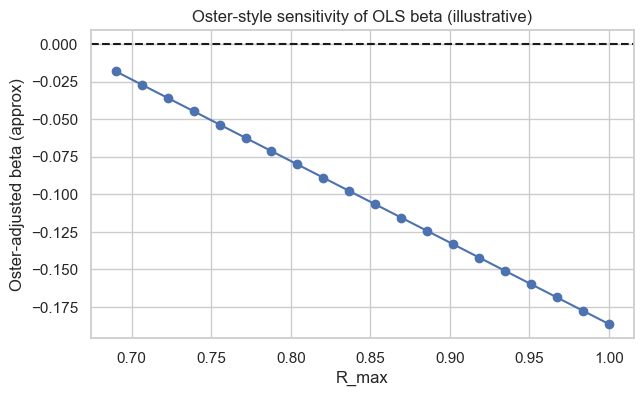

In [30]:
# CELL 5 (corrected): Oster-style sensitivity (approximate, robust to non-numeric cols)
# WARNING: OLS here is illustrative for Oster calculations; main DML is primary.

# 1) Build ols_df and coerce expected numeric covariates to numeric (coerce errors -> NaN)
ols_df = df[[idcol, timecol, Y_col, T_col] + covariates_to_use].copy()

# Coerce the columns that should be numeric to numeric (this will convert stray strings to NaN)
numeric_cols = [Y_col, T_col] + covariates_to_use
for c in numeric_cols:
    ols_df[c] = pd.to_numeric(ols_df[c], errors='coerce')

# Optional diagnostic: show columns that remain non-numeric (e.g., iso3c)
print("Remaining non-numeric columns:", ols_df.select_dtypes(exclude=[np.number]).columns.tolist())

# 2) Mean-impute only numeric columns (safe: compute mean for numeric columns only)
numeric_means = ols_df.select_dtypes(include=[np.number]).mean()
# fill numeric columns with their means; non-numeric columns (iso3c) are untouched
ols_df[numeric_means.index] = ols_df[numeric_means.index].fillna(numeric_means)

# 3) Baseline OLS: Y ~ T + year dummies
X_base = pd.get_dummies(ols_df[timecol], prefix='yr').astype(float)
X_base = X_base.join(ols_df[[T_col]])
X_base = sm.add_constant(X_base)
olsm_base = sm.OLS(ols_df[Y_col], X_base).fit()
beta_base = olsm_base.params[T_col]
R_base = olsm_base.rsquared

# 4) Full OLS: Y ~ T + X + year dummies
X_full = pd.get_dummies(ols_df[timecol], prefix='yr').astype(float).join(ols_df[covariates_to_use])
X_full = X_full.join(ols_df[[T_col]])
X_full = sm.add_constant(X_full)
olsm_full = sm.OLS(ols_df[Y_col], X_full).fit()
beta_full = olsm_full.params[T_col]
R_full = olsm_full.rsquared

print("OLS baseline beta:", beta_base, "R2:", R_base)
print("OLS full beta:", beta_full, "R2:", R_full)
print("DML theta:", theta_hat)

# 5) Oster adjustment (approx) over R_max grid
def oster_adjust(beta_full, beta_base, R_full, R_base, R_max):
    denom = (R_full - R_base)
    if denom == 0:
        return np.nan
    adj = beta_full - (R_max - R_full) / denom * (beta_full - beta_base)
    return adj

R_max_grid = np.linspace(R_full, min(1.0, R_full*1.5), 20)
oster_results = [(Rmax, oster_adjust(beta_full, beta_base, R_full, R_base, Rmax)) for Rmax in R_max_grid]
oster_df = pd.DataFrame(oster_results, columns=['R_max','beta_adj'])
oster_df.to_csv(os.path.join(fold_output_dir,'oster_adjustments.csv'), index=False)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(oster_df['R_max'], oster_df['beta_adj'], marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('R_max')
plt.ylabel('Oster-adjusted beta (approx)')
plt.title('Oster-style sensitivity of OLS beta (illustrative)')
plt.show()

CELL 6 — Permutation test (shuffle ND-GAIN across countries)

This builds an empirical null distribution of the DML theta by permuting gain across countries (preserves time structure within country). It re-runs the whole cross-fit DML loop for each permutation — may take time; set n_permutations accordingly.

Completed 20/200 permutations — elapsed 588s
Completed 40/200 permutations — elapsed 1838s
Completed 60/200 permutations — elapsed 2459s
Completed 80/200 permutations — elapsed 3186s
Completed 100/200 permutations — elapsed 3948s
Completed 120/200 permutations — elapsed 4438s
Completed 140/200 permutations — elapsed 5297s
Completed 160/200 permutations — elapsed 6599s
Completed 180/200 permutations — elapsed 7132s
Completed 200/200 permutations — elapsed 8602s
Completed permutations: 200
Empirical permutation p-value: 0.004975124378109453


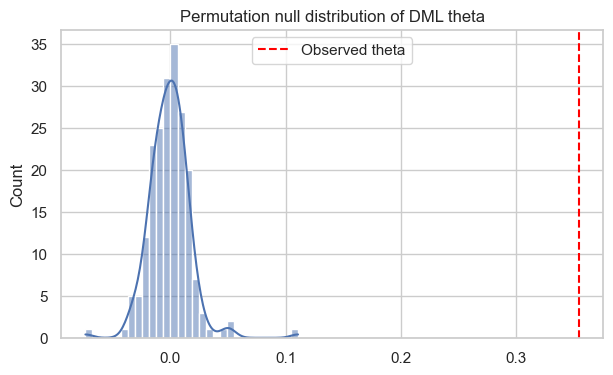

In [32]:
# CORRECTED CELL 6: robust permutation test (shuffle gain within each year) + robust DML function

import time
from sklearn.exceptions import NotFittedError

def dml_theta_on_df(df_local, covariates_list, n_trees_local=300, random_seed_local=2025):
    """
    Compact DML run (pooled with year FE), robust to NaNs in train/test by dropping obs where y or t are missing.
    Returns theta estimate (float). Does NOT persist models to disk to keep it fast in permutations.
    """
    years_local = sorted(df_local[timecol].unique())
    folds_local = [(df_local.index[df_local[timecol] != y].tolist(), df_local.index[df_local[timecol] == y].tolist()) for y in years_local]

    u_list_loc = []
    v_list_loc = []

    for fnum,(train_idx,test_idx) in enumerate(folds_local):
        train = df_local.loc[train_idx].copy()
        test  = df_local.loc[test_idx].copy()

        # Preprocess (no FE partial-out for pooled)
        prep = fold_aware_preprocess(train, test, covariates_list,
                                     idcol=idcol, ycol=Y_col, tcol=T_col,
                                     imputer=KNNImputer(n_neighbors=5),
                                     scaler=StandardScaler(),
                                     include_country_fe=False,
                                     save_prefix=None)  # do not save artifacts in permutation runs

        X_train = prep['X_train']; X_test = prep['X_test']
        y_train = prep['y_train']; y_test = prep['y_test']
        t_train = prep['t_train']; t_test = prep['t_test']

        # Add year dummies fitted on train (same as main loop)
        yrs_train = pd.get_dummies(train[timecol], prefix='yr')
        yrs_test  = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_train.columns, fill_value=0)
        yrs_train.index = train.index; yrs_test.index = test.index

        X_train_fe = pd.concat([X_train.reset_index(drop=True), yrs_train.reset_index(drop=True)], axis=1); X_train_fe.index = X_train.index
        X_test_fe  = pd.concat([X_test.reset_index(drop=True),  yrs_test.reset_index(drop=True)], axis=1); X_test_fe.index = X_test.index
        X_test_fe  = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0)

        # --- Drop training rows with missing y or missing t ---
        train_mask = (~y_train.isna()) & (~t_train.isna())
        if train_mask.sum() < max(10, int(0.05 * len(train_mask))):
            # too few train obs with both y and t -> skip this fold (no contribution)
            # (this occurs rarely if a year has extremely sparse data)
            # Continue to next fold without appending residuals
            continue

        Xtrain_sub = X_train_fe.loc[train_mask.index[train_mask]].copy()
        ytrain_sub = y_train.loc[train_mask.index[train_mask]].copy()
        ttrain_sub = t_train.loc[train_mask.index[train_mask]].copy()

        # Fit p(X) on the training subset; handle degenerate cases
        try:
            # if ttrain_sub is constant, LassoCV will fail; check variance
            if np.nanvar(ttrain_sub) == 0:
                # no variation in treatment in this training subset -> skip fold
                continue
            p_model = LassoCV(cv=5, random_state=random_seed_local).fit(Xtrain_sub, ttrain_sub)
        except Exception as e:
            # fallback: simple Lasso with default alpha or skip fold
            try:
                from sklearn.linear_model import Lasso
                p_model = Lasso(alpha=1.0).fit(Xtrain_sub, ttrain_sub)
            except Exception:
                continue

        # predict p-hat on the test set (but we'll only use entries with non-missing y and t)
        p_hat_test_full = p_model.predict(X_test_fe)

        # Fit m(X) on training subset
        try:
            m_model = RandomForestRegressor(n_estimators=n_trees_local, n_jobs=-1, random_state=random_seed_local)
            m_model.fit(Xtrain_sub, ytrain_sub)
        except Exception as e:
            # if RF fails for some reason, fallback to simple linear model
            m_model = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
            # wrap predict function to match API
            def m_predict(X): 
                return m_model.predict(sm.add_constant(X))
            m_hat_test_full = m_predict(X_test_fe)
        else:
            m_hat_test_full = m_model.predict(X_test_fe)

        # --- For the test fold, only keep indices where both y_test and t_test are observed (no NaNs) ---
        test_mask = (~y_test.isna()) & (~t_test.isna())
        if test_mask.sum() == 0:
            continue  # nothing to add from this fold

        index_keep = test_mask.index[test_mask]
        u_hat = y_test.loc[index_keep].values - m_hat_test_full[np.isin(X_test_fe.index, index_keep)]
        v_hat = t_test.loc[index_keep].values - p_hat_test_full[np.isin(X_test_fe.index, index_keep)]

        # Append
        u_list_loc.append(pd.Series(u_hat, index=index_keep))
        v_list_loc.append(pd.Series(v_hat, index=index_keep))

    # end folds
    if len(u_list_loc) == 0:
        # nothing to estimate (very unlikely)
        return np.nan

    u_all_loc = pd.concat(u_list_loc).sort_index()
    v_all_loc = pd.concat(v_list_loc).sort_index()
    theta_loc = (v_all_loc * u_all_loc).sum() / (v_all_loc**2).sum()
    return float(theta_loc)


# Permutation: shuffle gain across countries within each year
perm_thetas = []
start_time = time.time()
for perm in range(n_permutations):
    # build shuffled df by year: for each year, shuffle gain among countries present that year
    shuffled = df.copy()
    shuffled['gain_perm'] = np.nan
    for yr in shuffled[timecol].unique():
        mask = shuffled[timecol] == yr
        vals = shuffled.loc[mask, T_col].values
        # if all NaN, skip year
        if np.all(pd.isna(vals)):
            continue
        np.random.shuffle(vals)  # in-place shuffle
        shuffled.loc[mask, 'gain_perm'] = vals

    # ensure there are no NaNs in gain_perm where original had a value (if some years had fewer obs, we still align)
    # set the treatment column temporarily
    shuffled_temp = shuffled.copy()
    shuffled_temp[T_col] = shuffled_temp['gain_perm']

    # Optionally: drop rows where shuffled_temp[T_col] is NaN (rare)
    # but dml_theta_on_df will handle missing by skipping folds with insufficient data, so we can proceed.

    theta_perm = dml_theta_on_df(shuffled_temp, covariates_to_use, n_trees_local=n_trees, random_seed_local=random_seed)
    perm_thetas.append(theta_perm)

    if (perm+1) % 20 == 0:
        elapsed = time.time() - start_time
        print(f"Completed {perm+1}/{n_permutations} permutations — elapsed {elapsed:.0f}s")

# Remove NaN thetas if any (folds might have been skipped)
perm_thetas_clean = np.array([t for t in perm_thetas if not pd.isna(t)])
if len(perm_thetas_clean) == 0:
    print("No valid permutation thetas computed — check data coverage.")
else:
    p_emp = (np.sum(np.abs(perm_thetas_clean) >= np.abs(theta_hat)) + 1) / (len(perm_thetas_clean) + 1)
    print("Completed permutations:", len(perm_thetas_clean))
    print("Empirical permutation p-value:", p_emp)

    # plot
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(7,4))
    sns.histplot(perm_thetas_clean, kde=True, bins=30)
    plt.axvline(theta_hat, color='red', linestyle='--', label='Observed theta')
    plt.legend()
    plt.title('Permutation null distribution of DML theta')
    plt.show()

    # save
    pd.Series(perm_thetas_clean).to_csv(os.path.join(fold_output_dir,'perm_thetas_clean.csv'), index=False)

Cell 7 Placebo:

In [40]:
# 1. recreate placebo lead column safely and inspect
df_placebo = df.copy()

# create gain_lead1 (future ND-GAIN)
df_placebo['gain_lead1'] = df_placebo.groupby('iso3c')['gain'].shift(-1)

# drop rows where lead is missing (optional for placebo)
df_placebo_pl = df_placebo.dropna(subset=['gain_lead1']).copy()

# reset index to ensure unique integer index (very important)
df_placebo_pl = df_placebo_pl.reset_index(drop=True)

# check
print("placebo shape:", df_placebo_pl.shape)
print("Columns preview:", df_placebo_pl.columns[:30].tolist())
print("Does gain_lead1 exist and non-missing count:", df_placebo_pl['gain_lead1'].notna().sum())
print("Sample rows:")
display(df_placebo_pl[[ 'iso3c','year','gain','gain_lead1', Y_col ]].head(8))
print("\nDtypes of key cols:")
print(df_placebo_pl[[T_col, Y_col]].dtypes)

placebo shape: (1468, 65)
Columns preview: ['year', 'iso3c', 'yield_with_spread', 'sovereign_spread', 'cpi_yoy', 'gdp_annual_growth_rate', 'gdp_per_capita', 'gross gdp', 'debt_to_gdp', 'deficit_to_gdp', 'current_account_balance', 'vulnerability', 'wgi_cc', 'wgi_ge', 'wgi_pv', 'wgi_rl', 'wgi_rq', 'wgi_va', 'gain', 'country_mean', 'gain_diff1', 'ln_gdp_per_capita', 'ln_gross_gdp', 'sovereign_spread_lag1', 'sovereign_spread_lag2', 'cpi_yoy_lag1', 'cpi_yoy_lag2', 'gdp_annual_growth_rate_lag1', 'gdp_annual_growth_rate_lag2', 'ln_gdp_per_capita_lag1']
Does gain_lead1 exist and non-missing count: 1468
Sample rows:


,iso3c,year,gain,gain_lead1,sovereign_spread
0,ARG,2010,46.299003,45.844055,15.604236
1,ARG,2012,45.844055,45.512061,9.079577
2,ARG,2013,45.512061,45.076998,6.987068
3,ARG,2014,45.076998,44.899691,7.833954
4,ARG,2015,44.899691,46.512091,5.376118
5,ARG,2016,46.512091,46.441575,1.361908
6,ARG,2017,46.441575,48.315080,4.101448
7,ARG,2018,48.315080,48.720793,14.894352



Dtypes of key cols:
gain                float64
sovereign_spread    float64
dtype: object


In [41]:
# Paste and run this whole cell

import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import time

def dml_theta_on_df_debug(df_local, covariates_list, n_trees_local=100, random_seed_local=2025, verbose=True):
    """
    Robust pooled DML (year-FE) with fold-level diagnostics.
    Returns (theta, diagnostics_df)
    diagnostics_df has one row per fold with counts and reasons for skipping.
    """
    t0 = time.time()
    df_local = df_local.reset_index(drop=True).copy()   # ensure integer index
    years_local = sorted(df_local['year'].unique())
    folds_local = [(df_local.index[df_local['year'] != y].tolist(), df_local.index[df_local['year'] == y].tolist()) for y in years_local]

    u_list = []
    v_list = []
    diag_rows = []

    for fnum, (train_idx, test_idx) in enumerate(folds_local):
        train = df_local.loc[train_idx].reset_index(drop=True).copy()
        test  = df_local.loc[test_idx].reset_index(drop=True).copy()

        # Minimal diagnostics
        n_train = len(train)
        n_test  = len(test)

        # Preprocess (impute & scale on train only)
        prep = fold_aware_preprocess(train, test, covariates_list,
                                     idcol='iso3c', ycol=Y_col, tcol=T_col,
                                     imputer=KNNImputer(n_neighbors=5),
                                     scaler=StandardScaler(),
                                     include_country_fe=False,
                                     save_prefix=None)

        X_train = prep['X_train']; X_test = prep['X_test']
        y_train = prep['y_train']; y_test = prep['y_test']
        t_train = prep['t_train']; t_test = prep['t_test']

        # Year dummies fitted on train
        yrs_train = pd.get_dummies(train['year'], prefix='yr')
        yrs_test  = pd.get_dummies(test['year'], prefix='yr').reindex(columns=yrs_train.columns, fill_value=0)
        yrs_train = yrs_train.reset_index(drop=True)
        yrs_test  = yrs_test.reset_index(drop=True)

        X_train_fe = pd.concat([X_train.reset_index(drop=True), yrs_train], axis=1)
        X_test_fe  = pd.concat([X_test.reset_index(drop=True),  yrs_test], axis=1)
        X_test_fe  = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0)

        # use numpy arrays for masks
        y_train_arr = y_train.to_numpy()
        t_train_arr = t_train.to_numpy()
        train_mask = (~pd.isna(y_train_arr)) & (~pd.isna(t_train_arr))
        n_train_ok = int(train_mask.sum())
        train_variation = False
        if n_train_ok > 0:
            # check variation in treatment among usable rows
            ttrain_sub = t_train.iloc[np.where(train_mask)[0]]
            train_variation = (np.nanvar(ttrain_sub.to_numpy()) > 0)

        reason = ''
        if n_train_ok < max(10, int(0.05 * len(train_mask))):
            reason = 'too_few_train_rows'
        elif not train_variation:
            reason = 'no_t_variation_in_train'

        if reason != '':
            # skip fold but record diagnostics
            diag_rows.append({
                'fold': fnum, 'year_holdout': years_local[fnum],
                'n_train': n_train, 'n_test': n_test,
                'n_train_ok': n_train_ok, 'train_variation': train_variation,
                'used': False, 'reason': reason
            })
            if verbose:
                print(f"Fold {fnum} (holdout year {years_local[fnum]}): SKIPPED ({reason}), n_train_ok={n_train_ok}, n_test={n_test}")
            continue

        # get integer positions of usable training rows
        train_pos = np.where(train_mask)[0]
        Xtrain_sub = X_train_fe.iloc[train_pos, :].copy()
        ytrain_sub = y_train.iloc[train_pos].copy()
        ttrain_sub = t_train.iloc[train_pos].copy()

        # Fit p(X)
        try:
            p_model = LassoCV(cv=5, random_state=random_seed_local).fit(Xtrain_sub, ttrain_sub)
        except Exception:
            from sklearn.linear_model import Lasso
            p_model = Lasso(alpha=1.0).fit(Xtrain_sub, ttrain_sub)
        p_hat_test_full = p_model.predict(X_test_fe)

        # Fit m(X)
        try:
            m_model = RandomForestRegressor(n_estimators=n_trees_local, n_jobs=-1, random_state=random_seed_local)
            m_model.fit(Xtrain_sub, ytrain_sub)
            m_hat_test_full = m_model.predict(X_test_fe)
        except Exception:
            m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
            m_hat_test_full = m_ols.predict(sm.add_constant(X_test_fe))

        # test mask — positions where both y_test and t_test are not NaN
        y_test_arr = y_test.to_numpy()
        t_test_arr = t_test.to_numpy()
        test_mask = (~pd.isna(y_test_arr)) & (~pd.isna(t_test_arr))
        n_test_ok = int(test_mask.sum())
        if n_test_ok == 0:
            diag_rows.append({
                'fold': fnum, 'year_holdout': years_local[fnum],
                'n_train': n_train, 'n_test': n_test,
                'n_train_ok': n_train_ok, 'train_variation': train_variation,
                'n_test_ok': n_test_ok, 'used': False, 'reason': 'no_test_obs'
            })
            if verbose:
                print(f"Fold {fnum} (holdout year {years_local[fnum]}): SKIPPED (no usable test obs)")
            continue

        test_pos = np.where(test_mask)[0]
        p_hat_kept = p_hat_test_full[test_pos]
        m_hat_kept = m_hat_test_full[test_pos]

        index_keep = test.index[test_pos]
        u_hat = y_test_arr[test_pos] - m_hat_kept
        v_hat = t_test_arr[test_pos] - p_hat_kept

        u_list.append(pd.Series(u_hat, index=index_keep))
        v_list.append(pd.Series(v_hat, index=index_keep))

        diag_rows.append({
            'fold': fnum, 'year_holdout': years_local[fnum],
            'n_train': n_train, 'n_test': n_test,
            'n_train_ok': n_train_ok, 'train_variation': train_variation,
            'n_test_ok': n_test_ok, 'used': True, 'reason': ''
        })
        if verbose:
            print(f"Fold {fnum} (holdout year {years_local[fnum]}): USED, n_train_ok={n_train_ok}, n_test_ok={n_test_ok}, train_var={train_variation}")

    # end folds
    if len(u_list) == 0:
        if verbose:
            print("No folds contributed; returning NaN")
        return np.nan, pd.DataFrame(diag_rows)

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    theta = (v_all * u_all).sum() / (v_all**2).sum()
    if verbose:
        elapsed = time.time() - t0
        print(f"Done. theta={theta:.6g}. folds_used={sum([1 for r in diag_rows if r.get('used')])}/{len(diag_rows)}. elapsed={elapsed:.1f}s")
    return float(theta), pd.DataFrame(diag_rows)

# Now run the debug DML on your placebo panel
theta_placebo, diag_df = dml_theta_on_df_debug(df_placebo_pl, covariates_to_use, n_trees_local=100, random_seed_local=2025, verbose=True)

print("\nPer-fold diagnostics (first 20 rows):")
display(diag_df.head(20))

print("\nPlacebo theta:", theta_placebo)

Fold 0 (holdout year 1995): USED, n_train_ok=1438, n_test_ok=30, train_var=True
Fold 1 (holdout year 1996): USED, n_train_ok=1436, n_test_ok=32, train_var=True
Fold 2 (holdout year 1997): USED, n_train_ok=1434, n_test_ok=34, train_var=True
Fold 3 (holdout year 1998): USED, n_train_ok=1432, n_test_ok=36, train_var=True
Fold 4 (holdout year 1999): USED, n_train_ok=1430, n_test_ok=38, train_var=True
Fold 5 (holdout year 2000): USED, n_train_ok=1428, n_test_ok=40, train_var=True
Fold 6 (holdout year 2001): USED, n_train_ok=1426, n_test_ok=42, train_var=True
Fold 7 (holdout year 2002): USED, n_train_ok=1424, n_test_ok=44, train_var=True
Fold 8 (holdout year 2003): USED, n_train_ok=1422, n_test_ok=46, train_var=True
Fold 9 (holdout year 2004): USED, n_train_ok=1421, n_test_ok=47, train_var=True
Fold 10 (holdout year 2005): USED, n_train_ok=1420, n_test_ok=48, train_var=True
Fold 11 (holdout year 2006): USED, n_train_ok=1420, n_test_ok=48, train_var=True
Fold 12 (holdout year 2007): USED, n_t

,fold,year_holdout,n_train,n_test,n_train_ok,train_variation,n_test_ok,used,reason
0,0,1995,1438,30,1438,True,30,True,
1,1,1996,1436,32,1436,True,32,True,
2,2,1997,1434,34,1434,True,34,True,
3,3,1998,1432,36,1432,True,36,True,
4,4,1999,1430,38,1430,True,38,True,
5,5,2000,1428,40,1428,True,40,True,
6,6,2001,1426,42,1426,True,42,True,
7,7,2002,1424,44,1424,True,44,True,
8,8,2003,1422,46,1422,True,46,True,
9,9,2004,1421,47,1421,True,47,True,



Placebo theta: 0.3876333422616326


In [42]:
# === Compute SE for placebo theta ===
import pickle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# Make a copy and set temporary treatment name
df_temp = df_placebo_pl.copy().reset_index(drop=True).rename(columns={'gain_lead1':'gain_temp'})

# prepare fold list (leave-one-year-out)
years = sorted(df_temp['year'].unique())
folds = [(df_temp.index[df_temp['year'] != y].tolist(), df_temp.index[df_temp['year'] == y].tolist()) for y in years]

u_list = []
v_list = []

for fnum,(train_idx,test_idx) in enumerate(folds):
    train = df_temp.loc[train_idx].reset_index(drop=True).copy()
    test  = df_temp.loc[test_idx].reset_index(drop=True).copy()

    # preprocess (train-only impute/scale), note tcol uses 'gain_temp'
    prep = fold_aware_preprocess(train, test, covariates=covariates_to_use,
                                 idcol='iso3c', ycol=Y_col, tcol='gain_temp',
                                 imputer=KNNImputer(n_neighbors=5), scaler=StandardScaler(),
                                 include_country_fe=False, save_prefix=None)

    X_train = prep['X_train']; X_test = prep['X_test']
    y_train = prep['y_train']; y_test = prep['y_test']
    t_train = prep['t_train']; t_test = prep['t_test']

    # year dummies fitted on train
    yrs_train = pd.get_dummies(train['year'], prefix='yr')
    yrs_test  = pd.get_dummies(test['year'], prefix='yr').reindex(columns=yrs_train.columns, fill_value=0)
    yrs_train = yrs_train.reset_index(drop=True); yrs_test = yrs_test.reset_index(drop=True)
    X_train_fe = pd.concat([X_train.reset_index(drop=True), yrs_train], axis=1)
    X_test_fe  = pd.concat([X_test.reset_index(drop=True), yrs_test], axis=1)
    X_test_fe = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0)

    # drop rows with missing y or t on train
    train_mask = (~y_train.isna()) & (~t_train.isna())
    if train_mask.sum() < max(10, int(0.05 * len(train_mask))):
        continue
    train_pos = np.where(train_mask)[0]
    Xtrain_sub = X_train_fe.iloc[train_pos, :].copy()
    ytrain_sub = y_train.iloc[train_pos].copy()
    ttrain_sub = t_train.iloc[train_pos].copy()
    if np.nanvar(ttrain_sub) == 0:
        continue

    # fit p(X) and m(X)
    p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
    m_model = RandomForestRegressor(n_estimators=200, random_state=random_seed).fit(Xtrain_sub, ytrain_sub)
    p_hat_test = p_model.predict(X_test_fe)
    m_hat_test = m_model.predict(X_test_fe)

    # keep test rows where both y and t observed
    test_mask = (~y_test.isna()) & (~t_test.isna())
    if test_mask.sum() == 0:
        continue
    test_pos = np.where(test_mask)[0]
    index_keep = test.index[test_pos]

    p_hat_kept = p_hat_test[test_pos]
    m_hat_kept = m_hat_test[test_pos]
    u_hat = y_test.to_numpy()[test_pos] - m_hat_kept
    v_hat = t_test.to_numpy()[test_pos] - p_hat_kept

    u_list.append(pd.Series(u_hat, index=index_keep))
    v_list.append(pd.Series(v_hat, index=index_keep))

# stack residuals and estimate theta + cluster SE
u_all = pd.concat(u_list).sort_index()
v_all = pd.concat(v_list).sort_index()

theta_placebo_calc = (v_all * u_all).sum() / (v_all**2).sum()
print("Placebo theta (calc):", theta_placebo_calc)

# OLS for cluster-robust SE (cluster by iso3c)
res_placebo = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': df_temp.loc[u_all.index,'iso3c']})
print(res_placebo.summary())

Placebo theta (calc): 0.37548554967258607
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.119
Model:                            OLS   Adj. R-squared (uncentered):              0.119
Method:                 Least Squares   F-statistic:                              1.903
Date:                Fri, 22 Aug 2025   Prob (F-statistic):                       0.262
Time:                        10:38:53   Log-Likelihood:                         -4690.7
No. Observations:                1468   AIC:                                      9383.
Df Residuals:                    1467   BIC:                                      9389.
Df Model:                           1                                                  
Covariance Type:              cluster                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]

Lead thetas: {0: 0.3466555825510748, 1: 0.3850055098700622, 2: 0.3935410222940255}


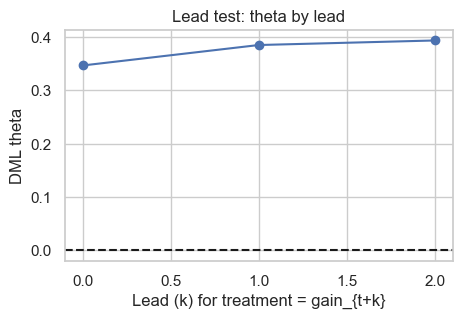

In [43]:
# compute DML theta for lead 0 (current), lead1 and lead2 using the same function but minimal output
def compute_lead_theta(k):
    df_k = df.copy().reset_index(drop=True)
    df_k[f'gain_lead{k}'] = df_k.groupby('iso3c')['gain'].shift(-k)
    df_k = df_k.dropna(subset=[f'gain_lead{k}', Y_col]).reset_index(drop=True)
    df_k = df_k.rename(columns={f'gain_lead{k}':'gain_temp'})
    try:
        theta_k = dml_theta_on_df_debug(df_k, covariates_to_use, n_trees_local=150, random_seed_local=random_seed, verbose=False)[0]
    except Exception:
        theta_k = np.nan
    return theta_k

leads = [0,1,2]
lead_thetas = {k: compute_lead_theta(k) for k in leads}
print("Lead thetas:", lead_thetas)

# quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(list(lead_thetas.keys()), list(lead_thetas.values()), marker='o')
plt.xlabel('Lead (k) for treatment = gain_{t+k}')
plt.ylabel('DML theta')
plt.title('Lead test: theta by lead')
plt.axhline(0, color='k', linestyle='--')
plt.show()

In [46]:
# Save a comprehensive results package for the DML project
import os, json, pickle
import pandas as pd
import numpy as np
import statsmodels as sm
from datetime import datetime
import sys

OUT_DIR = "artifacts/dml_results_full"
os.makedirs(OUT_DIR, exist_ok=True)

def safe_pickle(obj, path):
    try:
        with open(path, "wb") as f:
            pickle.dump(obj, f)
        return True
    except Exception as e:
        print(f"Could not pickle to {path}: {e}")
        return False

def safe_csv(df, path):
    try:
        df.to_csv(path, index=True)
        return True
    except Exception as e:
        print(f"Could not save CSV {path}: {e}")
        return False

def safe_text(txt, path):
    try:
        with open(path, "w", encoding="utf-8") as f:
            f.write(txt)
        return True
    except Exception as e:
        print(f"Could not save text {path}: {e}")
        return False

manifest = []

# 1) main summary (if exists)
try:
    summary = {
        'dml_theta': float(theta_hat) if 'theta_hat' in globals() else None,
        'dml_coef': float(res.params[0]) if 'res' in globals() and hasattr(res,'params') else None,
        'cluster_se': float(res.bse[0]) if 'res' in globals() and hasattr(res,'bse') else None,
        't_stat': float(res.tvalues[0]) if 'res' in globals() and hasattr(res,'tvalues') else None,
        'p_val': float(res.pvalues[0]) if 'res' in globals() and hasattr(res,'pvalues') else None,
        'median_p_oos_r2': float(np.nanmedian(p_oos_r2_folds)) if 'p_oos_r2_folds' in globals() else None,
        'median_m_oos_r2': float(np.nanmedian(m_oos_r2_folds)) if 'm_oos_r2_folds' in globals() else None,
        'mde80': float(mde80) if 'mde80' in globals() else None,
        'perm_pval': float(p_emp) if 'p_emp' in globals() else None,
        'placebo_theta': float(theta_placebo) if 'theta_placebo' in globals() else None
    }
    pd.Series(summary).to_csv(os.path.join(OUT_DIR, "summary_overview.csv"))
    with open(os.path.join(OUT_DIR, "summary_overview.json"), "w") as f:
        json.dump(summary, f, indent=2)
    manifest.append("summary_overview.csv / .json")
except Exception as e:
    print("Could not save main summary:", e)

# 2) Save DML regression text summary (statsmodels res)
if 'res' in globals():
    try:
        txt = res.summary().as_text()
        safe_text(txt, os.path.join(OUT_DIR, "dml_regression_summary.txt"))
        manifest.append("dml_regression_summary.txt")
    except Exception as e:
        print("Failed to save res.summary():", e)

# 3) Save per-fold nuisance metrics (p_oos_r2_folds, m_oos_r2_folds)
if 'p_oos_r2_folds' in globals():
    try:
        pd.DataFrame({'p_oos_r2': p_oos_r2_folds}).to_csv(os.path.join(OUT_DIR, "p_oos_r2_folds.csv"), index_label="fold")
        manifest.append("p_oos_r2_folds.csv")
    except Exception as e:
        print("Could not save p_oos_r2_folds:", e)

if 'm_oos_r2_folds' in globals():
    try:
        pd.DataFrame({'m_oos_r2': m_oos_r2_folds}).to_csv(os.path.join(OUT_DIR, "m_oos_r2_folds.csv"), index_label="fold")
        manifest.append("m_oos_r2_folds.csv")
    except Exception as e:
        print("Could not save m_oos_r2_folds:", e)

# 4) Save stacked residuals (u_all, v_all) if present
if 'u_all' in globals() and 'v_all' in globals():
    try:
        stacked = pd.DataFrame({'u_hat': u_all, 'v_hat': v_all})
        stacked.to_csv(os.path.join(OUT_DIR, "stacked_residuals_uv_all.csv"))
        manifest.append("stacked_residuals_uv_all.csv")
    except Exception as e:
        print("Could not save stacked residuals:", e)

# 5) Save per-fold artifacts list if present (per_fold_artifacts)
if 'per_fold_artifacts' in globals():
    try:
        # try to save as JSON-friendly structure
        pf = per_fold_artifacts
        with open(os.path.join(OUT_DIR, "per_fold_artifacts.json"), "w") as f:
            json.dump(pf, f, indent=2)
        manifest.append("per_fold_artifacts.json")
    except Exception as e:
        print("Could not save per_fold_artifacts:", e)

# 6) Save covariate manifest if exists
if os.path.exists("artifacts/covariate_manifest.csv"):
    try:
        os.replace("artifacts/covariate_manifest.csv", os.path.join(OUT_DIR, "covariate_manifest.csv"))
        manifest.append("covariate_manifest.csv")
    except Exception:
        # if replace fails, copy instead
        try:
            df_cov = pd.read_csv("artifacts/covariate_manifest.csv")
            df_cov.to_csv(os.path.join(OUT_DIR, "covariate_manifest.csv"), index=False)
            manifest.append("covariate_manifest.csv")
        except Exception as e:
            print("Could not move covariate_manifest.csv:", e)

# 7) Save permutation results if present (perm_thetas_clean or perm_thetas)
if 'perm_thetas_clean' in globals():
    pd.Series(perm_thetas_clean).to_csv(os.path.join(OUT_DIR, "perm_thetas_clean.csv"), index=False)
    manifest.append("perm_thetas_clean.csv")
elif 'perm_thetas' in globals():
    pd.Series(perm_thetas).to_csv(os.path.join(OUT_DIR, "perm_thetas.csv"), index=False)
    manifest.append("perm_thetas.csv")

# 8) Save Oster adjustments if present (oster_df)
if 'oster_df' in globals():
    try:
        oster_df.to_csv(os.path.join(OUT_DIR, "oster_adjustments.csv"), index=False)
        manifest.append("oster_adjustments.csv")
    except Exception as e:
        print("Could not save oster_df:", e)

# 9) Save placebo diagnostics and theta if present (diag_df, theta_placebo)
if 'diag_df' in globals():
    try:
        diag_df.to_csv(os.path.join(OUT_DIR, "placebo_diag_df.csv"), index=False)
        manifest.append("placebo_diag_df.csv")
    except Exception:
        pass

if 'theta_placebo' in globals():
    try:
        pd.Series({'theta_placebo': float(theta_placebo)}).to_csv(os.path.join(OUT_DIR, "placebo_theta.csv"))
        manifest.append("placebo_theta.csv")
    except Exception as e:
        print("Could not save placebo theta:", e)

# 10) Save per-fold model pickles if they exist in fold_output_dir (those were saved by earlier loop)
if 'fold_output_dir' in globals() and os.path.exists(fold_output_dir):
    try:
        # copy all pickles and files in fold_output_dir to OUT_DIR/folds/
        import shutil
        dest_folddir = os.path.join(OUT_DIR, "fold_models")
        if os.path.exists(dest_folddir):
            shutil.rmtree(dest_folddir)
        shutil.copytree(fold_output_dir, dest_folddir)
        manifest.append("fold_models/ (copied from fold_output_dir)")
    except Exception as e:
        print("Could not copy fold_output_dir artifacts:", e)

# 11) Save DML diagnostics table if exists (diag_df from debug run or main per-fold diag)
if 'diag_df' in globals():
    try:
        diag_df.to_csv(os.path.join(OUT_DIR, "dml_placebo_fold_diagnostics.csv"), index=False)
        manifest.append("dml_placebo_fold_diagnostics.csv")
    except Exception as e:
        print("Could not save diag_df:", e)

# 12) Save the main data snapshot used for analysis (optional, may be large)
if 'df' in globals():
    try:
        df.to_csv(os.path.join(OUT_DIR, "analysis_panel_snapshot.csv"), index=False)
        manifest.append("analysis_panel_snapshot.csv")
    except Exception as e:
        print("Could not save data snapshot (might be large):", e)

# 13) Save environment/versions info
try:
    versions = {
        'python': sys.version.replace('\n',' '),
        'pandas': pd.__version__,
        'numpy': np.__version__,
        'sklearn': None
    }
    try:
        import sklearn
        versions['sklearn'] = sklearn.__version__
    except Exception:
        pass
    with open(os.path.join(OUT_DIR, "env_versions.json"), "w") as f:
        json.dump(versions, f, indent=2)
    manifest.append("env_versions.json")
except Exception as e:
    print("Could not save env versions:", e)

# 14) Write README manifest
readme_lines = [
    "DML Project - Results package",
    f"Generated: {datetime.utcnow().isoformat()} UTC",
    "",
    "Files included (best-effort):",
]
for m in manifest:
    readme_lines.append("- " + m)
readme_lines.append("")
readme_lines.append("Notes:")
readme_lines.append("- summary_overview contains key scalars to inspect quickly.")
readme_lines.append("- dml_regression_summary contains the statsmodels OLS on residuals (clustered SEs).")
readme_lines.append("- stacked_residuals_uv_all.csv contains the u and v residuals used in the final orthogonal regression.")
readme_lines.append("- fold_models/ holds per-fold pickled nuisances (if they were saved during modeling).")
readme_lines.append("- analysis_panel_snapshot.csv is a CSV snapshot of the data used; remove if too large or sensitive.")
safe_text("\n".join(readme_lines), os.path.join(OUT_DIR, "README.txt"))

print("Saved results to:", OUT_DIR)
print("Files saved (manifest):")
for m in manifest:
    print(" -", m)

Saved results to: artifacts/dml_results_full
Files saved (manifest):
 - summary_overview.csv / .json
 - dml_regression_summary.txt
 - p_oos_r2_folds.csv
 - m_oos_r2_folds.csv
 - stacked_residuals_uv_all.csv
 - per_fold_artifacts.json
 - perm_thetas_clean.csv
 - oster_adjustments.csv
 - placebo_diag_df.csv
 - placebo_theta.csv
 - fold_models/ (copied from fold_output_dir)
 - dml_placebo_fold_diagnostics.csv
 - analysis_panel_snapshot.csv
 - env_versions.json


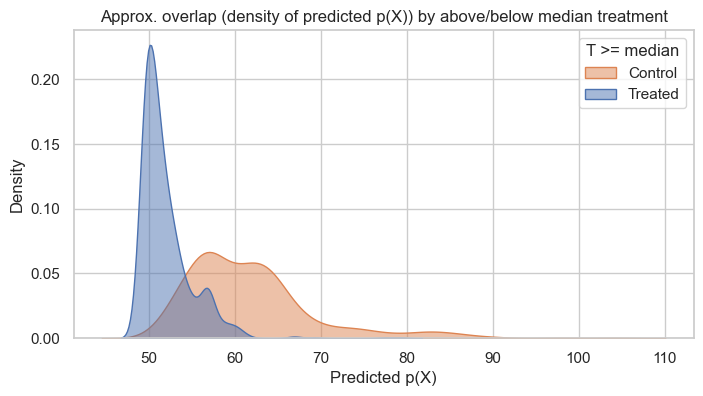

<Figure size 1000x500 with 0 Axes>

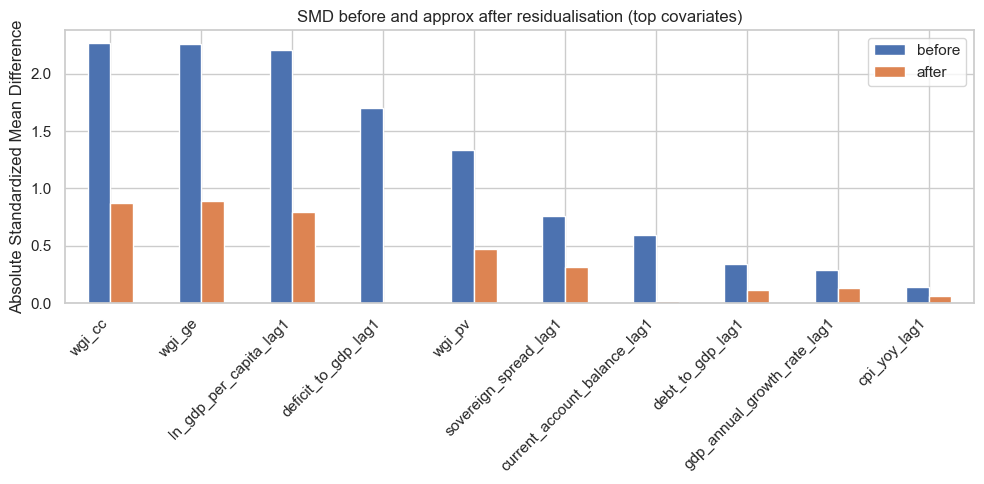

Overlap and SMD diagnostics saved to: artifacts/dml_pooled


In [47]:
# CELL 9 (UPDATED): Overlap & SMD plots (robust)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
sns.set(style='whitegrid')

# Defensive copy
ols_df = df[[idcol, timecol, Y_col, T_col] + covariates_to_use].copy()

# 1) Coerce expected numeric covariates to numeric (errors -> NaN)
# We'll treat the covariates_to_use as numeric candidates; convert them safely
for c in covariates_to_use:
    ols_df[c] = pd.to_numeric(ols_df[c], errors='coerce')

# Also ensure outcome and treatment are numeric
ols_df[Y_col] = pd.to_numeric(ols_df[Y_col], errors='coerce')
ols_df[T_col] = pd.to_numeric(ols_df[T_col], errors='coerce')

# 2) Mean-impute only numeric columns (for this diagnostic only)
numeric_cols = ols_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_means = ols_df[numeric_cols].mean()
ols_df[numeric_cols] = ols_df[numeric_cols].fillna(numeric_means)

# 3) Build X_ov for p(X) overlap visualization: year dummies + numeric covariates
year_dummies = pd.get_dummies(ols_df[timecol], prefix='yr').astype(float)
X_ov = pd.concat([year_dummies.reset_index(drop=True), ols_df[covariates_to_use].reset_index(drop=True)], axis=1)
# final safety: ensure no NaNs remain in X_ov numeric columns
X_ov = X_ov.fillna(X_ov.mean())

# 4) Fit a single p(X) (Lasso) on full sample for overlap approx (diagnostic only)
try:
    p_full = LassoCV(cv=5, random_state=random_seed).fit(X_ov, ols_df[T_col])
    p_hat_full = p_full.predict(X_ov)
    ols_df['p_hat_full'] = p_hat_full
except Exception as e:
    # fallback to simple linear model if LassoCV fails
    print("LassoCV failed, falling back to OLS for p_hat. Error:", e)
    lm_px = sm.OLS(ols_df[T_col], sm.add_constant(X_ov)).fit()
    ols_df['p_hat_full'] = lm_px.predict(sm.add_constant(X_ov))

# 5) Overlap plot: density of predicted p(X) by treated vs control (above/below median of T)
ols_df['treated_flag'] = (ols_df[T_col] >= np.nanmedian(ols_df[T_col])).astype(int)
plt.figure(figsize=(8,4))
sns.kdeplot(data=ols_df, x='p_hat_full', hue='treated_flag', fill=True, common_norm=False,
            palette=['C0','C1'], alpha=0.5)
plt.title('Approx. overlap (density of predicted p(X)) by above/below median treatment')
plt.xlabel('Predicted p(X)')
plt.legend(title='T >= median', labels=['Control','Treated'])
plt.show()

# 6) SMD before/after residualisation
# Choose covariates to show in SMD plot: take first 10 numeric covariates from covariates_to_use
covariates_for_smd = [c for c in covariates_to_use if c in ols_df.select_dtypes(include=[np.number]).columns][:10]
if len(covariates_for_smd) == 0:
    raise ValueError("No numeric covariates available for SMD calculation. Check covariates_to_use.")

def compute_smd(df_in, treat_col, covs):
    treated = df_in[df_in[treat_col] >= df_in[treat_col].median()]
    control = df_in[df_in[treat_col] < df_in[treat_col].median()]
    smd = {}
    for c in covs:
        m_t = treated[c].mean()
        m_c = control[c].mean()
        sd_pooled = np.sqrt((treated[c].var(ddof=1) + control[c].var(ddof=1)) / 2)
        smd[c] = np.abs(m_t - m_c) / (sd_pooled + 1e-8)
    return pd.Series(smd)

smd_before = compute_smd(ols_df, T_col, covariates_for_smd)

# Residualise each covariate on p_hat_full (approximate effect of adjusting for X)
resid_df = ols_df.copy()
for c in covariates_for_smd:
    # regress covariate on p_hat_full and take residuals
    try:
        lm = sm.OLS(resid_df[c].astype(float), sm.add_constant(resid_df['p_hat_full'])).fit()
        resid_df[c + '_res'] = lm.resid
    except Exception:
        # if regression fails (e.g., constant column), set residuals to zero
        resid_df[c + '_res'] = 0.0

smd_after = compute_smd(resid_df, T_col, [c + '_res' for c in covariates_for_smd])

# Build SMD table and plot top 10 covariates by before-SMD
smd_plot = pd.DataFrame({'before': smd_before, 'after': smd_after.values}, index=smd_before.index)
smd_plot = smd_plot.sort_values('before', ascending=False).head(10)

plt.figure(figsize=(10,5))
smd_plot.plot.bar(figsize=(10,5))
plt.ylabel('Absolute Standardized Mean Difference')
plt.title('SMD before and approx after residualisation (top covariates)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7) Save the computed p_hat_full and SMD table for record (if desired)
save_dir = fold_output_dir if 'fold_output_dir' in globals() else "artifacts"
os.makedirs(save_dir, exist_ok=True)
ols_df[['p_hat_full', 'treated_flag'] + covariates_for_smd].to_csv(os.path.join(save_dir, "overlap_p_hat_full_sample.csv"), index=False)
smd_plot.to_csv(os.path.join(save_dir, "smd_before_after_top10.csv"))

print("Overlap and SMD diagnostics saved to:", save_dir)

# Attempt 2

##

	1.	Run Step 1 (lead tests k=0..3) and compute ND-GAIN autocorr. Post results here.

ND-GAIN lag-1 autocorrelation summary (per-country):


,gain
count,67.000000
mean,0.855970
std,0.233551
min,-0.816893
25%,0.824241
50%,0.922249
75%,0.963503
max,0.990227
median,0.922249
iqr,0.139262


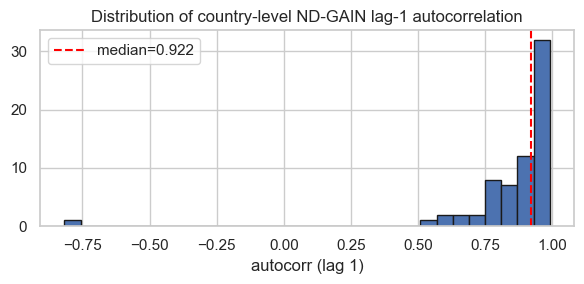

In [48]:
# Cell A: ND-GAIN autocorrelation by country (lag-1)
import pandas as pd
import numpy as np

# compute lag-1 autocorrelation for each country
autocorrs = df.groupby('iso3c')['gain'].apply(lambda s: s.autocorr(lag=1)).dropna()
autocorr_summary = autocorrs.describe().to_frame().T
autocorr_summary['median'] = autocorrs.median()
autocorr_summary['iqr'] = autocorrs.quantile(0.75) - autocorrs.quantile(0.25)

print("ND-GAIN lag-1 autocorrelation summary (per-country):")
display(autocorr_summary.T)

# Save to CSV
autocorrs.to_csv(os.path.join(fold_output_dir, "gain_autocorr_by_country.csv"))
autocorr_summary.to_csv(os.path.join(fold_output_dir, "gain_autocorr_summary.csv"))

# Quick histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(autocorrs.dropna(), bins=30, edgecolor='k')
plt.axvline(autocorrs.median(), color='red', linestyle='--', label=f"median={autocorrs.median():.3f}")
plt.title("Distribution of country-level ND-GAIN lag-1 autocorrelation")
plt.xlabel("autocorr (lag 1)")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Cell B: helper to compute DML theta and cluster-robust SE (pooled, LOYO cross-fit).
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

def compute_dml_theta_and_se(df_local,
                             covariates_list,
                             idcol='iso3c',
                             timecol='year',
                             ycol='sovereign_spread',
                             tcol='gain_temp',
                             n_trees=200,
                             random_seed=2025,
                             min_train_frac=0.05):
    """
    Runs pooled cross-fitted DML (leave-one-year-out) and returns:
      - theta (point estimate)
      - cluster-robust OLS result on residuals (res object)
      - u_all (pd.Series), v_all (pd.Series), groups (pd.Series of iso3c for u_all index)
    Requires fold_aware_preprocess in the notebook.
    """
    years = sorted(df_local[timecol].unique())
    folds = [(df_local.index[df_local[timecol] != y].tolist(), df_local.index[df_local[timecol] == y].tolist()) for y in years]

    u_list = []
    v_list = []
    groups_list = []

    for fnum, (train_idx, test_idx) in enumerate(folds):
        train = df_local.loc[train_idx].reset_index(drop=True).copy()
        test  = df_local.loc[test_idx].reset_index(drop=True).copy()

        # Preprocess: impute & scale on train only, no FE partial-out (pooled)
        prep = fold_aware_preprocess(train, test, covariates=covariates_list,
                                     idcol=idcol, ycol=ycol, tcol=tcol,
                                     imputer=KNNImputer(n_neighbors=5),
                                     scaler=StandardScaler(),
                                     include_country_fe=False, save_prefix=None)

        X_train = prep['X_train']; X_test = prep['X_test']
        y_train = prep['y_train']; y_test = prep['y_test']
        t_train = prep['t_train']; t_test = prep['t_test']

        # Year dummies fitted on train
        yrs_train = pd.get_dummies(train[timecol], prefix='yr')
        yrs_test  = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_train.columns, fill_value=0)
        yrs_train = yrs_train.reset_index(drop=True); yrs_test = yrs_test.reset_index(drop=True)

        X_train_fe = pd.concat([X_train.reset_index(drop=True), yrs_train], axis=1)
        X_test_fe  = pd.concat([X_test.reset_index(drop=True),  yrs_test], axis=1)
        X_test_fe  = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0)

        # Use numpy arrays for masks; safe selection by positions
        y_train_arr = y_train.to_numpy()
        t_train_arr = t_train.to_numpy()
        train_mask_arr = (~pd.isna(y_train_arr)) & (~pd.isna(t_train_arr))
        n_train_ok = int(train_mask_arr.sum())
        if n_train_ok < max(10, int(min_train_frac * len(train_mask_arr))):
            # skip fold if too few usable train rows
            continue

        train_pos = np.where(train_mask_arr)[0]
        Xtrain_sub = X_train_fe.iloc[train_pos, :].copy()
        ytrain_sub = y_train.iloc[train_pos].copy()
        ttrain_sub = t_train.iloc[train_pos].copy()

        # require variation in t
        if np.nanvar(ttrain_sub.to_numpy()) == 0:
            continue

        # fit p(X) and m(X)
        try:
            p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
        except Exception:
            from sklearn.linear_model import Lasso
            p_model = Lasso(alpha=1.0).fit(Xtrain_sub, ttrain_sub)
        p_hat_test_full = p_model.predict(X_test_fe)

        try:
            m_model = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1, random_state=random_seed)
            m_model.fit(Xtrain_sub, ytrain_sub)
            m_hat_test_full = m_model.predict(X_test_fe)
        except Exception:
            m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
            m_hat_test_full = m_ols.predict(sm.add_constant(X_test_fe))

        # test mask: require y_test and t_test present
        y_test_arr = y_test.to_numpy(); t_test_arr = t_test.to_numpy()
        test_mask_arr = (~pd.isna(y_test_arr)) & (~pd.isna(t_test_arr))
        if test_mask_arr.sum() == 0:
            continue

        test_pos = np.where(test_mask_arr)[0]

        # predictions for kept positions
        p_hat_kept = p_hat_test_full[test_pos]
        m_hat_kept = m_hat_test_full[test_pos]

        u_hat = y_test_arr[test_pos] - m_hat_kept
        v_hat = t_test_arr[test_pos] - p_hat_kept

        # groups for cluster (iso3c) - pick values from test DataFrame for kept positions
        groups_kept = test.loc[test_pos, idcol].reset_index(drop=True)

        # build Series indexed by a unique label: use cumulative counter index to avoid duplicates
        # we will use incremental integer keys to avoid index alignment issues later
        base_idx = len(u_list) * 10**6  # large offset to keep uniqueness (simple)
        idxs = [base_idx + i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=idxs))
        v_list.append(pd.Series(v_hat, index=idxs))
        groups_list.append(pd.Series(groups_kept.values, index=idxs))

    if len(u_list) == 0:
        return dict(theta=np.nan, res=None, u_all=None, v_all=None, groups=None)

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups_all = pd.concat(groups_list).sort_index()

    # DML theta
    theta = (v_all * u_all).sum() / (v_all**2).sum()

    # cluster-robust inference: regress u on v, cluster by groups_all
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups_all.values})
    return dict(theta=float(theta), res=res, u_all=u_all, v_all=v_all, groups=groups_all)

Lead 0: theta=0.346826, se=0.2812348209763999, t=1.2332248136467794, p=0.2174919000940182
Lead 1: theta=0.375486, se=0.26426121167154176, t=1.4208878680965422, p=0.1553493604689083
Lead 2: theta=0.374388, se=0.26844240928770957, t=1.394666680790342, p=0.16311637690748737
Lead 3: theta=0.387155, se=0.2849786858848831, t=1.3585405748734805, p=0.17429221683149765


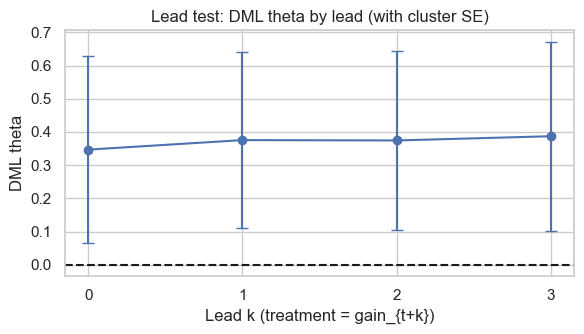

Saved lead results to: artifacts/dml_pooled/lead_thetas_k0_3.csv


<Figure size 640x480 with 0 Axes>

In [50]:
# Cell C: loop over leads 0..3, compute theta and cluster SE
lead_results = []
for k in [0,1,2,3]:
    # create dataset with lead k: gain_{t+k} (future gain for k>=1); for k=0 use current gain
    df_k = df.copy().reset_index(drop=True)
    if k == 0:
        df_k['gain_temp'] = df_k['gain']
    else:
        df_k['gain_temp'] = df_k.groupby('iso3c')['gain'].shift(-k)

    # drop rows without treatment or outcome
    df_k = df_k.dropna(subset=['gain_temp', Y_col]).reset_index(drop=True)

    out = compute_dml_theta_and_se(df_k, covariates_to_use,
                                   idcol='iso3c', timecol='year',
                                   ycol=Y_col, tcol='gain_temp',
                                   n_trees=200, random_seed=2025)

    theta = out['theta']
    res = out['res']
    if res is not None:
        se = float(res.bse[0])
        tstat = float(res.tvalues[0])
        pval = float(res.pvalues[0])
    else:
        se = np.nan; tstat = np.nan; pval = np.nan

    lead_results.append({'lead_k': k, 'theta': theta, 'se': se, 'tstat': tstat, 'pval': pval})

    print(f"Lead {k}: theta={theta:.6g}, se={se}, t={tstat}, p={pval}")

# aggregate results to DataFrame and save
lead_df = pd.DataFrame(lead_results)
lead_df.to_csv(os.path.join(fold_output_dir, "lead_thetas_k0_3.csv"), index=False)

# plot with error bars
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3.5))
plt.errorbar(lead_df['lead_k'], lead_df['theta'], yerr=lead_df['se'], fmt='o-', capsize=4)
plt.axhline(0, color='k', linestyle='--')
plt.xticks(lead_df['lead_k'])
plt.xlabel('Lead k (treatment = gain_{t+k})')
plt.ylabel('DML theta')
plt.title('Lead test: DML theta by lead (with cluster SE)')
plt.tight_layout()
plt.show()

# Save plot
plt.savefig(os.path.join(fold_output_dir, "lead_theta_plot_k0_3.png"), dpi=200, bbox_inches='tight')
print("Saved lead results to:", os.path.join(fold_output_dir, "lead_thetas_k0_3.csv"))

A — Run lagged-treatment DML (gain_{t−1}) — High priority

Why: uses pre-treatment exposure, removes mechanical persistence problem.
What to run: the lagged DML cell I gave (CELL 1).
Save: dml_lag1_summary.csv (theta, SE, p).
What to paste here: the printed theta, SE, p from the cell.


In [51]:
# CELL: DML with lagged treatment (gain_{t-1})
df_lag1 = df.copy().reset_index(drop=True)
df_lag1['gain_lag1'] = df_lag1.groupby('iso3c')['gain'].shift(1)

# drop rows with missing lagged treatment or outcome
df_lag1 = df_lag1.dropna(subset=['gain_lag1', Y_col]).reset_index(drop=True)

# rename for compatibility with helper (tcol = 'gain_temp')
df_lag1 = df_lag1.rename(columns={'gain_lag1': 'gain_temp'})

out_lag1 = compute_dml_theta_and_se(df_lag1, covariates_to_use,
                                    idcol='iso3c', timecol='year',
                                    ycol=Y_col, tcol='gain_temp',
                                    n_trees=200, random_seed=2025)

theta_lag1 = out_lag1['theta']
res_lag1 = out_lag1['res']
print("Lagged treatment DML (gain_{t-1})")
print("theta_lag1 =", theta_lag1)
if res_lag1 is not None:
    print("SE (cluster):", float(res_lag1.bse[0]), "t:", float(res_lag1.tvalues[0]), "p:", float(res_lag1.pvalues[0]))
else:
    print("Cluster result NA (likely no folds contributed).")

# save
import pandas as pd, os
pd.DataFrame([{'spec':'lag1','theta':theta_lag1,
               'se': float(res_lag1.bse[0]) if res_lag1 is not None else None,
               'pval': float(res_lag1.pvalues[0]) if res_lag1 is not None else None}]
            ).to_csv(os.path.join(fold_output_dir, "dml_lag1_summary.csv"), index=False)

Lagged treatment DML (gain_{t-1})
theta_lag1 = 0.4607589973175241
SE (cluster): 0.33710072376720807 t: 1.3668288580587884 p: 0.1716789551307546


B — Distributed-lag residual regression — High priority (run right after A)

Why: separates immediate vs delayed associations (gain_t vs gain_{t−1}, gain_{t−2}).
What to run: the distributed-lag cell I gave (CELL 2). It uses LOYO residualisation then OLS y_res ~ gain_t + gain_lag1 + gain_lag2 with clustered SEs.
Save: distributed_lag_results.csv and the regression text (or paste the summary).
What to paste here: the coefficients, SEs, p-values for gain_t, gain_lag1, gain_lag2.

In [55]:
# FIXED CELL: run distributed-lag regressions on nested samples + diagnostics
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure resid_df exists from previous cell
print("Rows in resid_df:", len(resid_df))

# Make sure lag columns are numeric and finite
for col in ['gain_t','gain_lag1','gain_lag2']:
    if col in resid_df.columns:
        resid_df[col] = pd.to_numeric(resid_df[col], errors='coerce')
        resid_df.loc[np.isinf(resid_df[col]), col] = np.nan
    else:
        resid_df[col] = np.nan

# Drop rows with missing y_res (should not happen)
resid_df = resid_df.dropna(subset=['y_res']).reset_index(drop=True)
print("Rows after dropping missing y_res:", len(resid_df))

# Helper to run clustered OLS and save + print results
def run_cluster_ols(df_sub, regressors, cluster_col='iso3c', save_prefix='model'):
    X = df_sub[regressors].astype(float)
    X = sm.add_constant(X)
    y = df_sub['y_res'].astype(float)
    clusters = df_sub[cluster_col].astype(object)
    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': clusters})
    print("\n=== Regression:", save_prefix, " (N=", len(df_sub), ") ===")
    print(model.summary())
    # save coef table
    coef_tbl = pd.DataFrame({'coef': model.params, 'se': model.bse, 'pval': model.pvalues})
    coef_tbl.to_csv(os.path.join(fold_output_dir, f"{save_prefix}_coef_table.csv"))
    # VIF if more than 1 regressor (excluding constant)
    if len(regressors) > 1:
        vif_df = pd.DataFrame()
        vif_df['variable'] = ['const'] + regressors
        try:
            # compute VIF for regressors (exclude constant for VIF calc)
            X_vif = df_sub[regressors].astype(float).dropna()
            # add constant column to compute VIFs in usual way
            X_vif_const = sm.add_constant(X_vif)
            vif_vals = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]
            vif_df['VIF'] = vif_vals
        except Exception as e:
            vif_df['VIF'] = np.nan
        vif_df.to_csv(os.path.join(fold_output_dir, f"{save_prefix}_vif.csv"))
        print("Saved coef table and VIF to fold_output_dir.")
    else:
        print("Saved coef table to fold_output_dir.")
    return model

# Model A: y_res ~ gain_t (drop rows missing gain_t)
df_A = resid_df.dropna(subset=['gain_t']).copy().reset_index(drop=True)
model_A = None
if len(df_A) > 0:
    model_A = run_cluster_ols(df_A, ['gain_t'], save_prefix='distlag_model_A_gain_t')

# Model B: y_res ~ gain_t + gain_lag1 (require both)
df_B = resid_df.dropna(subset=['gain_t','gain_lag1']).copy().reset_index(drop=True)
model_B = None
if len(df_B) > 0:
    # display correlation between gain_t and gain_lag1
    corr12 = df_B['gain_t'].corr(df_B['gain_lag1'])
    print("\nCorrelation(gain_t, gain_lag1) in Model B sample:", corr12)
    model_B = run_cluster_ols(df_B, ['gain_t','gain_lag1'], save_prefix='distlag_model_B_gain_t_lag1')

# Model C: y_res ~ gain_t + gain_lag1 + gain_lag2 (require all 3)
df_C = resid_df.dropna(subset=['gain_t','gain_lag1','gain_lag2']).copy().reset_index(drop=True)
model_C = None
if len(df_C) > 0:
    corr_mat = df_C[['gain_t','gain_lag1','gain_lag2']].corr()
    print("\nCorrelation matrix of lags in Model C sample:")
    display(corr_mat)
    model_C = run_cluster_ols(df_C, ['gain_t','gain_lag1','gain_lag2'], save_prefix='distlag_model_C_gain_t_lag1_lag2')

# Summarize sample sizes
print("\nSample sizes: Model A (gain_t) =", len(df_A), "; Model B (t, t-1) =", len(df_B), "; Model C (t,t-1,t-2) =", len(df_C))

# Save the three datasets for inspection
df_A.to_csv(os.path.join(fold_output_dir, "distlag_sample_A_gain_t.csv"), index=False)
df_B.to_csv(os.path.join(fold_output_dir, "distlag_sample_B_gain_t_lag1.csv"), index=False)
df_C.to_csv(os.path.join(fold_output_dir, "distlag_sample_C_gain_t_lag1_lag2.csv"), index=False)

print("Saved sample CSVs and model outputs to:", fold_output_dir)

Rows in resid_df: 1535
Rows after dropping missing y_res: 1535

=== Regression: distlag_model_A_gain_t  (N= 1535 ) ===
                            OLS Regression Results                            
Dep. Variable:                  y_res   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     3.302
Date:                Fri, 22 Aug 2025   Prob (F-statistic):             0.0737
Time:                        11:53:23   Log-Likelihood:                -4978.7
No. Observations:                1535   AIC:                             9961.
Df Residuals:                    1533   BIC:                             9972.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

,gain_t,gain_lag1,gain_lag2
gain_t,1.000000,0.995683,0.991107
gain_lag1,0.995683,1.000000,0.995645
gain_lag2,0.991107,0.995645,1.000000



=== Regression: distlag_model_C_gain_t_lag1_lag2  (N= 1401 ) ===
                            OLS Regression Results                            
Dep. Variable:                  y_res   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9301
Date:                Fri, 22 Aug 2025   Prob (F-statistic):              0.431
Time:                        11:53:23   Log-Likelihood:                -3956.6
No. Observations:                1401   AIC:                             7921.
Df Residuals:                    1397   BIC:                             7942.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

CELL 3 — FE-DML (within-country DML)

This reuses the DML routine but sets include_country_fe=True in preprocessing so the nuisances are estimated on demeaned data (country FE partial-out). I provide a modified helper wrapper.

In [57]:
# CELL 3 (FE-DML): within-country Double Machine Learning with leave-one-year-out cross-fitting
import numpy as np
import pandas as pd
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import time

# Parameters (modify if desired)
n_trees = 300
random_seed = 2025
min_train_frac = 0.05   # minimum fraction of train rows required (same as pooled helper)
min_train_rows_absolute = 10

# Defensive checks
assert 'df' in globals(), "Dataframe `df` not found in the notebook environment."
assert 'covariates_to_use' in globals(), "Please ensure `covariates_to_use` is defined."
assert 'Y_col' in globals() and 'T_col' in globals(), "Please ensure Y_col and T_col are defined."
fold_output_dir = fold_output_dir if 'fold_output_dir' in globals() else "artifacts"
os.makedirs(fold_output_dir, exist_ok=True)

def compute_fe_dml(df_local, covariates_list, idcol='iso3c', timecol='year',
                   ycol=Y_col, tcol='gain', n_trees_local=n_trees, random_seed_local=random_seed,
                   min_train_frac_local=min_train_frac, min_train_rows=min_train_rows_absolute):
    """
    FE-DML: For each LOYO fold:
      - compute country means on TRAIN for y, t, and covariates (demean = within-FE)
      - apply the train means to both train and test (skip rows where a given country has no train mean)
      - impute/scale on train, fit p(X) with Lasso and m(X) with RF on demeaned data
      - predict on test, form residuals, stack u and v, cluster by iso3c
    Returns dictionary with theta, res (clustered OLS), u_all, v_all, groups_all, and diagnostics_df.
    """
    t0 = time.time()
    df_local = df_local.reset_index(drop=True).copy()
    years = sorted(df_local[timecol].unique())
    folds = [(df_local.index[df_local[timecol] != y].tolist(), df_local.index[df_local[timecol] == y].tolist()) for y in years]

    u_list = []
    v_list = []
    groups_list = []
    diag_rows = []

    for fnum, (train_idx, test_idx) in enumerate(folds):
        year_holdout = years[fnum]
        train = df_local.loc[train_idx].reset_index(drop=True).copy()
        test  = df_local.loc[test_idx].reset_index(drop=True).copy()

        # --- compute within-country means on TRAIN only ---
        # columns to demean: y, t, covariates (coerce numeric)
        demean_cols = [ycol, tcol] + [c for c in covariates_list if c in train.columns]
        # coerce numeric where possible
        train_demean = train[demean_cols].apply(pd.to_numeric, errors='coerce')
        # group means by country (train only)
        country_means = train.groupby(idcol)[demean_cols].mean()

        # For train and test, attach country means (NaN if country not in train)
        def attach_means(df_part):
            # join on country id; result has columns like <col>_mean
            means = df_part[[idcol]].merge(country_means.reset_index(), on=idcol, how='left', suffixes=('','_mean'))
            # means columns now include idcol plus demean_cols
            return means

        train_means = attach_means(train)
        test_means  = attach_means(test)

        # Demean: subtract country means for each column (only where mean present)
        # build demeaned DataFrames for y, t, and covariates
        # If a row's country mean is NaN => that country had no train observations (rare) -> drop those rows
        valid_train_mask = ~train_means[demean_cols].isna().any(axis=1)
        valid_test_mask  = ~test_means[demean_cols].isna().any(axis=1)

        n_train = len(train); n_test = len(test)
        n_train_valid = int(valid_train_mask.sum())
        n_test_valid = int(valid_test_mask.sum())

        # record diagnostics
        diag = {
            'fold': fnum, 'year_holdout': year_holdout,
            'n_train_total': n_train, 'n_test_total': n_test,
            'n_train_valid': n_train_valid, 'n_test_valid': n_test_valid,
            'used': False, 'reason': ''
        }

        if n_train_valid < max(min_train_rows, int(min_train_frac_local * n_train)):
            diag['used'] = False
            diag['reason'] = 'insufficient_valid_train_rows'
            diag_rows.append(diag)
            # skip fold
            continue

        # Subset to valid rows and compute demeaned values
        train_valid = train.loc[valid_train_mask].reset_index(drop=True).copy()
        test_valid  = test.loc[valid_test_mask].reset_index(drop=True).copy()
        train_means_valid = train_means.loc[valid_train_mask, demean_cols].reset_index(drop=True)
        test_means_valid  = test_means.loc[valid_test_mask, demean_cols].reset_index(drop=True)

        # produce demeaned series
        y_train_demean = pd.to_numeric(train_valid[ycol], errors='coerce') - train_means_valid[ycol]
        t_train_demean = pd.to_numeric(train_valid[tcol], errors='coerce') - train_means_valid[tcol]

        y_test_demean = pd.to_numeric(test_valid[ycol], errors='coerce') - test_means_valid[ycol]
        t_test_demean = pd.to_numeric(test_valid[tcol], errors='coerce') - test_means_valid[tcol]

        # Demean covariates
        covs_present = [c for c in covariates_list if c in train_valid.columns]
        X_train = train_valid[covs_present].apply(pd.to_numeric, errors='coerce') - train_means_valid[covs_present].values
        X_test  = test_valid[covs_present].apply(pd.to_numeric, errors='coerce') - test_means_valid[covs_present].values

        # Impute & scale on TRAIN demeaned covariates, then transform test
        try:
            imputer = KNNImputer(n_neighbors=5)
            X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
        except Exception:
            X_train_imp = X_train.fillna(X_train.mean())
            X_test_imp  = X_test.fillna(X_train.mean())

        try:
            scaler = StandardScaler()
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_imp.columns)
            X_test_scaled  = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns)
        except Exception:
            X_train_scaled = X_train_imp
            X_test_scaled = X_test_imp

        # Check that we have usable y and t in training subset
        train_valid_mask_y_t = (~y_train_demean.isna()) & (~t_train_demean.isna())
        if train_valid_mask_y_t.sum() < max(min_train_rows, int(min_train_frac_local * len(train_valid_mask_y_t))):
            diag['used'] = False
            diag['reason'] = 'insufficient_train_y_t'
            diag_rows.append(diag)
            continue

        # Select train rows by positions
        train_pos = np.where(train_valid_mask_y_t)[0]
        Xtrain_sub = X_train_scaled.iloc[train_pos, :].copy()
        ytrain_sub = y_train_demean.iloc[train_pos].copy()
        ttrain_sub = t_train_demean.iloc[train_pos].copy()

        # require variation in t in training subset
        if np.nanvar(ttrain_sub.to_numpy()) == 0:
            diag['used'] = False
            diag['reason'] = 'no_t_variation_in_train'
            diag_rows.append(diag)
            continue

        # Fit nuisance p(X) and m(X) on demeaned training subset
        try:
            p_model = LassoCV(cv=5, random_state=random_seed_local).fit(Xtrain_sub, ttrain_sub)
        except Exception:
            from sklearn.linear_model import Lasso
            p_model = Lasso(alpha=1.0).fit(Xtrain_sub, ttrain_sub)
        p_hat_test_full = p_model.predict(X_test_scaled)

        try:
            m_model = RandomForestRegressor(n_estimators=n_trees_local, n_jobs=-1, random_state=random_seed_local)
            m_model.fit(Xtrain_sub, ytrain_sub)
            m_hat_test_full = m_model.predict(X_test_scaled)
        except Exception:
            m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
            m_hat_test_full = m_ols.predict(sm.add_constant(X_test_scaled))

        # For the test_valid rows, we also need y_test_demean and t_test_demean arrays
        y_test_arr = y_test_demean.to_numpy()
        t_test_arr = t_test_demean.to_numpy()
        # keep positions with both y and t observed
        test_mask_pos = (~pd.isna(y_test_arr)) & (~pd.isna(t_test_arr))
        if test_mask_pos.sum() == 0:
            diag['used'] = False
            diag['reason'] = 'no_usable_test_obs'
            diag_rows.append(diag)
            continue

        pos_keep = np.where(test_mask_pos)[0]
        p_hat_kept = p_hat_test_full[pos_keep]
        m_hat_kept = m_hat_test_full[pos_keep]
        u_hat = y_test_arr[pos_keep] - m_hat_kept
        v_hat = t_test_arr[pos_keep] - p_hat_kept

        # collect iso3c groups for the kept test rows (original test_valid rows)
        groups_kept = test_valid.loc[pos_keep, idcol].astype(object).values

        # create unique integer indices to avoid index collisions
        base_idx = fnum * 10**6
        idxs = [base_idx + i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=idxs))
        v_list.append(pd.Series(v_hat, index=idxs))
        groups_list.append(pd.Series(groups_kept, index=idxs))

        diag['used'] = True
        diag['reason'] = ''
        diag['n_kept'] = int(len(u_hat))
        diag_rows.append(diag)

    # end folds
    if len(u_list) == 0:
        return {'theta': np.nan, 'res': None, 'u_all': None, 'v_all': None, 'groups': None, 'diag_df': pd.DataFrame(diag_rows)}

    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups_all = pd.concat(groups_list).sort_index()

    theta = (v_all * u_all).sum() / (v_all**2).sum()

    # cluster-robust regression of u on v
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups_all.values})

    diag_df = pd.DataFrame(diag_rows)
    elapsed = time.time() - t0
    print(f"FE-DML completed in {elapsed:.1f}s: theta={theta:.6g}. folds considered={len(folds)}, folds used={diag_df['used'].sum()}")
    return {'theta': float(theta), 'res': res, 'u_all': u_all, 'v_all': v_all, 'groups': groups_all, 'diag_df': diag_df}

# Run FE-DML using current gain as treatment
print("Running FE-DML (country fixed effects) using treatment =", T_col)
out_fe = compute_fe_dml(df, covariates_to_use, idcol='iso3c', timecol='year',
                        ycol=Y_col, tcol=T_col, n_trees_local=n_trees, random_seed_local=random_seed,
                        min_train_frac_local=min_train_frac, min_train_rows=min_train_rows_absolute)

theta_fe = out_fe['theta']
res_fe = out_fe['res']
diag_df_fe = out_fe['diag_df']

# Print key summary
print("\nFE-DML summary:")
print("theta_FE =", theta_fe)
if res_fe is not None:
    try:
        print("cluster SE:", float(res_fe.bse[0]), "t:", float(res_fe.tvalues[0]), "p:", float(res_fe.pvalues[0]))
    except Exception:
        print("Cluster regression produced no standard errors.")
else:
    print("No cluster regression produced (res is None).")

# Save outputs for inspection
diag_df_fe.to_csv(os.path.join(fold_output_dir, "fe_dml_fold_diagnostics.csv"), index=False)
if out_fe['u_all'] is not None and out_fe['v_all'] is not None:
    pd.DataFrame({'u_all': out_fe['u_all'], 'v_all': out_fe['v_all'], 'groups': out_fe['groups']}).to_csv(os.path.join(fold_output_dir, "fe_dml_uv_groups.csv"))
print("Diagnostics and residuals saved to:", fold_output_dir)

# Show first rows of diag_df
display(diag_df_fe.head(30))

Running FE-DML (country fixed effects) using treatment = gain
FE-DML completed in 19.7s: theta=-0.439007. folds considered=29, folds used=29

FE-DML summary:
theta_FE = -0.43900733250253493
cluster SE: 0.4419756320303412 t: -0.9932840199488586 p: 0.3205715628398762
Diagnostics and residuals saved to: artifacts/dml_pooled


,fold,year_holdout,n_train_total,n_test_total,n_train_valid,n_test_valid,used,reason,n_kept
0,0,1995,1505,30,1318,27,True,,27
1,1,1996,1503,32,1316,29,True,,29
2,2,1997,1501,34,1314,31,True,,31
3,3,1998,1499,36,1312,33,True,,33
4,4,1999,1497,38,1310,35,True,,35
5,5,2000,1495,40,1308,37,True,,37
6,6,2001,1493,42,1306,39,True,,39
7,7,2002,1491,44,1304,41,True,,41
8,8,2003,1489,46,1304,41,True,,41
9,9,2004,1488,47,1303,42,True,,42


CELL 4 — Quick outlier check (2014 big jumps) and re-run a sensitivity exclusion

This lists the largest year-to-year changes and provides an option to exclude those country-year observations (or just 2014) and re-run the lagged DML quickly.

In [58]:
# CELL: find large year-to-year ND-GAIN jumps and optionally drop year 2014 observations
df_changes = df.copy().reset_index(drop=True)
df_changes['gain_diff1'] = df_changes.groupby('iso3c')['gain'].diff()
top_jumps = df_changes[['iso3c','year','gain_diff1']].dropna().sort_values('gain_diff1').head(10)
top_jumps_tail = df_changes[['iso3c','year','gain_diff1']].dropna().sort_values('gain_diff1', ascending=False).head(10)
print("Top negative year-to-year drops (largest negatives):")
display(top_jumps.head(10))
print("Top positive jumps:")
display(top_jumps_tail.head(10))

# Option: exclude year 2014 (or exclude specific country-years)
exclude_year = 2014
df_no2014 = df[df['year'] != exclude_year].reset_index(drop=True)
df_no2014 = df_no2014.dropna(subset=[Y_col]).reset_index(drop=True)

# Rerun lagged DML on the filtered dataset (example)
df_no2014['gain_lag1'] = df_no2014.groupby('iso3c')['gain'].shift(1)
df_no2014 = df_no2014.dropna(subset=['gain_lag1', Y_col]).reset_index(drop=True)
df_no2014 = df_no2014.rename(columns={'gain_lag1':'gain_temp'})

out_no2014 = compute_dml_theta_and_se(df_no2014, covariates_to_use,
                                      idcol='iso3c', timecol='year',
                                      ycol=Y_col, tcol='gain_temp',
                                      n_trees=200, random_seed=2025)
print("Lagged DML excluding year 2014: theta =", out_no2014['theta'])
if out_no2014['res'] is not None:
    print("SE:", float(out_no2014['res'].bse[0]), "p:", float(out_no2014['res'].pvalues[0]))

Top negative year-to-year drops (largest negatives):


,iso3c,year,gain_diff1
118,BGD,2014,-11.062157
1017,NGA,2014,-10.871986
639,IND,2014,-9.909187
1133,PAK,2014,-8.339038
913,MEX,2014,-7.692216
264,CHN,2014,-7.237966
610,IDN,2014,-7.195652
1297,RUS,2014,-5.826981
310,CYP,2009,-5.246734
164,BRA,2014,-5.023341


Top positive jumps:


,iso3c,year,gain_diff1
1125,PAK,2006,4.643101
856,LUX,2006,4.566886
307,CYP,2006,4.188920
934,MLT,2006,4.076457
850,LUX,2000,4.020964
905,MEX,2006,4.000531
750,JPN,2006,3.980954
631,IND,2006,3.873623
1289,RUS,2006,3.788579
110,BGD,2006,3.679263


Lagged DML excluding year 2014: theta = 0.47422025187460043
SE: 0.345763687779606 p: 0.17021431976986523


# Trying pooled version

In [59]:
# POOLED DML vs POOLED + MUNDAK (country-means) — LOYO cross-fitting, no leakage
import numpy as np, pandas as pd, os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# Parameters
idcol = 'iso3c'
timecol = 'year'
ycol = Y_col
tcol = T_col
covs = [c for c in covariates_to_use if c in df.columns]
mundlak_covs = covs  # choose a subset if you prefer, e.g., economic vars only

def run_pooled_and_mundlak(df_local, covariates_list, mundlak_list,
                           idcol='iso3c', timecol='year', ycol=Y_col, tcol=T_col,
                           n_trees=200, random_seed=2025):
    years = sorted(df_local[timecol].unique())
    folds = [(df_local.index[df_local[timecol] != y].tolist(), df_local.index[df_local[timecol] == y].tolist()) for y in years]

    # holders for pooled residual stacking
    u_pooled = []; v_pooled = []; g_pooled = []
    u_mund = []; v_mund = []; g_mund = []
    for fnum, (train_idx, test_idx) in enumerate(folds):
        train = df_local.loc[train_idx].reset_index(drop=True).copy()
        test  = df_local.loc[test_idx].reset_index(drop=True).copy()

        # ============ POOLED (no Mundlak) ============
        # Build X_train / X_test from covariates; impute and scale on train
        Xtr = train[covariates_list].apply(pd.to_numeric, errors='coerce')
        Xte = test[covariates_list].apply(pd.to_numeric, errors='coerce')
        try:
            imp = KNNImputer(n_neighbors=5)
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns)
            Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns)
        except:
            Xtr_imp = Xtr.fillna(Xtr.mean()); Xte_imp = Xte.fillna(Xtr.mean())
        try:
            sc = StandardScaler()
            Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns)
            Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns)
        except:
            Xtr_s = Xtr_imp; Xte_s = Xte_imp

        yrs_tr = pd.get_dummies(train[timecol], prefix='yr').reset_index(drop=True)
        yrs_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0).reset_index(drop=True)
        Xtr_fe = pd.concat([Xtr_s.reset_index(drop=True), yrs_tr], axis=1)
        Xte_fe = pd.concat([Xte_s.reset_index(drop=True), yrs_te], axis=1)
        Xte_fe = Xte_fe.reindex(columns=Xtr_fe.columns, fill_value=0)

        y_tr = pd.to_numeric(train[ycol], errors='coerce'); t_tr = pd.to_numeric(train[tcol], errors='coerce')
        y_te = pd.to_numeric(test[ycol], errors='coerce'); t_te = pd.to_numeric(test[tcol], errors='coerce')

        # masks
        train_mask = (~y_tr.isna()) & (~t_tr.isna())
        if train_mask.sum() >= 10 and np.nanvar(t_tr[train_mask].to_numpy()) > 0:
            pos = np.where(train_mask)[0]
            Xtrain_sub = Xtr_fe.iloc[pos,:].copy(); ytrain_sub = y_tr.iloc[pos].copy(); ttrain_sub = t_tr.iloc[pos].copy()
            # fit p and m
            try:
                p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
            except:
                from sklearn.linear_model import Lasso
                p_model = Lasso().fit(Xtrain_sub, ttrain_sub)
            p_hat_test = p_model.predict(Xte_fe)
            try:
                m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(Xtrain_sub, ytrain_sub)
                m_hat_test = m_model.predict(Xte_fe)
            except:
                m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
                m_hat_test = m_ols.predict(sm.add_constant(Xte_fe))
            # test mask for pooling
            test_mask = (~y_te.isna()) & (~t_te.isna())
            if test_mask.sum() > 0:
                tp = np.where(test_mask)[0]
                u_vals = y_te.to_numpy()[tp] - m_hat_test[tp]
                v_vals = t_te.to_numpy()[tp] - p_hat_test[tp]
                base = fnum * 1000000
                idxs = [base + i for i in range(len(u_vals))]
                u_pooled.append(pd.Series(u_vals, index=idxs))
                v_pooled.append(pd.Series(v_vals, index=idxs))
                g_pooled.append(pd.Series(test.loc[tp, idcol].values, index=idxs))

        # ============ MUNDAK: compute country means on TRAIN and append to covariates ============
        # Compute train country means for mundlak_list
        mund_means = train.groupby(idcol)[mundlak_list].mean().reset_index()
        # attach means to train and test (left join), rows with NaN means on test => that country absent in train -> drop
        train_with_means = train.merge(mund_means, on=idcol, how='left', suffixes=('','_mean'))
        test_with_means  = test.merge(mund_means, on=idcol, how='left', suffixes=('','_mean'))
        # drop rows in train/test where any of the newly attached means are NaN (i.e., country not present in train)
        cols_mean = [c + '_mean' for c in mundlak_list]
        valid_train_mask = ~train_with_means[cols_mean].isna().any(axis=1)
        valid_test_mask  = ~test_with_means[cols_mean].isna().any(axis=1)
        if valid_train_mask.sum() < 10 or valid_test_mask.sum() == 0:
            # not enough valid rows -> skip mundlak for this fold
            continue
        train_valid = train_with_means.loc[valid_train_mask].reset_index(drop=True)
        test_valid  = test_with_means.loc[valid_test_mask].reset_index(drop=True)

        # build X matrices for mundlak: original demeaned pipeline (but here pooled; we just append means)
        Xtr_m = train_valid[covariates_list].apply(pd.to_numeric, errors='coerce')
        Xte_m = test_valid[covariates_list].apply(pd.to_numeric, errors='coerce')
        # append mean cols
        for cm in cols_mean:
            Xtr_m[cm] = train_valid[cm]
            Xte_m[cm] = test_valid[cm]

        try:
            imp2 = KNNImputer(n_neighbors=5)
            Xtr_m_imp = pd.DataFrame(imp2.fit_transform(Xtr_m), columns=Xtr_m.columns)
            Xte_m_imp = pd.DataFrame(imp2.transform(Xte_m), columns=Xte_m.columns)
        except:
            Xtr_m_imp = Xtr_m.fillna(Xtr_m.mean()); Xte_m_imp = Xte_m.fillna(Xtr_m.mean())
        try:
            sc2 = StandardScaler()
            Xtr_m_s = pd.DataFrame(sc2.fit_transform(Xtr_m_imp), columns=Xtr_m_imp.columns)
            Xte_m_s = pd.DataFrame(sc2.transform(Xte_m_imp), columns=Xte_m_imp.columns)
        except:
            Xtr_m_s = Xtr_m_imp; Xte_m_s = Xte_m_imp

        yrs_tr2 = pd.get_dummies(train_valid[timecol], prefix='yr').reset_index(drop=True)
        yrs_te2 = pd.get_dummies(test_valid[timecol], prefix='yr').reindex(columns=yrs_tr2.columns, fill_value=0).reset_index(drop=True)
        Xtr_m_fe = pd.concat([Xtr_m_s.reset_index(drop=True), yrs_tr2], axis=1)
        Xte_m_fe = pd.concat([Xte_m_s.reset_index(drop=True), yrs_te2], axis=1)
        Xte_m_fe = Xte_m_fe.reindex(columns=Xtr_m_fe.columns, fill_value=0)

        y_tr2 = pd.to_numeric(train_valid[ycol], errors='coerce'); t_tr2 = pd.to_numeric(train_valid[tcol], errors='coerce')
        y_te2 = pd.to_numeric(test_valid[ycol], errors='coerce'); t_te2 = pd.to_numeric(test_valid[tcol], errors='coerce')

        train_mask2 = (~y_tr2.isna()) & (~t_tr2.isna())
        if train_mask2.sum() >= 10 and np.nanvar(t_tr2[train_mask2].to_numpy()) > 0:
            pos2 = np.where(train_mask2)[0]
            Xtrain_sub2 = Xtr_m_fe.iloc[pos2,:].copy(); ytrain_sub2 = y_tr2.iloc[pos2].copy(); ttrain_sub2 = t_tr2.iloc[pos2].copy()
            try:
                p_model2 = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub2, ttrain_sub2)
            except:
                from sklearn.linear_model import Lasso
                p_model2 = Lasso().fit(Xtrain_sub2, ttrain_sub2)
            p_hat_test2 = p_model2.predict(Xte_m_fe)
            try:
                m_model2 = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(Xtrain_sub2, ytrain_sub2)
                m_hat_test2 = m_model2.predict(Xte_m_fe)
            except:
                m_ols2 = sm.OLS(ytrain_sub2.values, sm.add_constant(Xtrain_sub2)).fit()
                m_hat_test2 = m_ols2.predict(sm.add_constant(Xte_m_fe))

            test_mask2 = (~y_te2.isna()) & (~t_te2.isna())
            if test_mask2.sum() > 0:
                tp2 = np.where(test_mask2)[0]
                u_vals2 = y_te2.to_numpy()[tp2] - m_hat_test2[tp2]
                v_vals2 = t_te2.to_numpy()[tp2] - p_hat_test2[tp2]
                base2 = fnum * 1000000 + 500000
                idxs2 = [base2 + i for i in range(len(u_vals2))]
                u_mund.append(pd.Series(u_vals2, index=idxs2))
                v_mund.append(pd.Series(v_vals2, index=idxs2))
                g_mund.append(pd.Series(test_valid.loc[tp2, idcol].values, index=idxs2))

    # end folds
    # pooled
    if len(u_pooled) > 0:
        u_p_all = pd.concat(u_pooled).sort_index(); v_p_all = pd.concat(v_pooled).sort_index(); groups_p = pd.concat(g_pooled).sort_index()
        theta_p = (v_p_all * u_p_all).sum() / (v_p_all**2).sum()
        res_p = sm.OLS(u_p_all.values, v_p_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups_p.values})
    else:
        theta_p = np.nan; res_p = None
    # mundlak
    if len(u_mund) > 0:
        u_m_all = pd.concat(u_mund).sort_index(); v_m_all = pd.concat(v_mund).sort_index(); groups_m = pd.concat(g_mund).sort_index()
        theta_m = (v_m_all * u_m_all).sum() / (v_m_all**2).sum()
        res_m = sm.OLS(u_m_all.values, v_m_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups_m.values})
    else:
        theta_m = np.nan; res_m = None

    return {'theta_pooled': theta_p, 'res_pooled': res_p, 'theta_mundlak': theta_m, 'res_mundlak': res_m}

# Run
out_both = run_pooled_and_mundlak(df, covs, mundlak_covs, idcol=idcol, timecol=timecol, ycol=ycol, tcol=tcol)
print("Pooled theta:", out_both['theta_pooled'])
if out_both['res_pooled'] is not None:
    print("Pooled SE:", float(out_both['res_pooled'].bse[0]), "p:", float(out_both['res_pooled'].pvalues[0]))
print("Mundlak theta:", out_both['theta_mundlak'])
if out_both['res_mundlak'] is not None:
    print("Mundlak SE:", float(out_both['res_mundlak'].bse[0]), "p:", float(out_both['res_mundlak'].pvalues[0]))

# Save
import pandas as pd, os
pd.DataFrame([{'spec':'pooled','theta':out_both['theta_pooled'],'se':float(out_both['res_pooled'].bse[0]) if out_both['res_pooled'] is not None else None,
               'pval': float(out_both['res_pooled'].pvalues[0]) if out_both['res_pooled'] is not None else None},
              {'spec':'mundlak','theta':out_both['theta_mundlak'],'se':float(out_both['res_mundlak'].bse[0]) if out_both['res_mundlak'] is not None else None,
               'pval': float(out_both['res_mundlak'].pvalues[0]) if out_both['res_mundlak'] is not None else None}]
            ).to_csv(os.path.join(fold_output_dir, "pooled_vs_mundlak_results.csv"), index=False)

print("Saved pooled_vs_mundlak_results.csv to", fold_output_dir)

Pooled theta: 0.34682575968960616
Pooled SE: 0.2812348209763999 p: 0.2174919000940182
Mundlak theta: -0.034804738371167016
Mundlak SE: 0.021237227626079387 p: 0.10124344489192784
Saved pooled_vs_mundlak_results.csv to artifacts/dml_pooled


In [60]:
# LOCO for lagged DML (run quickly; earlier code)
countries = sorted(df['iso3c'].unique())
loco_results = []
for c in countries:
    df_loco = df[df['iso3c'] != c].copy().reset_index(drop=True)
    df_loco['gain_lag1'] = df_loco.groupby('iso3c')['gain'].shift(1)
    df_loco = df_loco.dropna(subset=['gain_lag1', Y_col]).reset_index(drop=True)
    if len(df_loco) < 100:
        continue
    df_loco = df_loco.rename(columns={'gain_lag1': 'gain_temp'})
    out = compute_dml_theta_and_se(df_loco, covariates_to_use, idcol='iso3c', timecol='year',
                                   ycol=Y_col, tcol='gain_temp', n_trees=200, random_seed=2025)
    loco_results.append({'country_left_out': c, 'theta': out['theta'],
                         'se': float(out['res'].bse[0]) if out['res'] is not None else None})
loco_df = pd.DataFrame(loco_results).sort_values('theta')
loco_df.to_csv(os.path.join(fold_output_dir, "loco_lag1_results.csv"), index=False)
display(loco_df.head(8)); display(loco_df.tail(8))

KeyboardInterrupt: 

In [ ]:
# DML with treatment = year-to-year change in gain (gain_diff1)
df_diff = df.copy().reset_index(drop=True)
df_diff['gain_diff1'] = df_diff.groupby('iso3c')['gain'].diff()
# use lagged diff if you want pre-treatment (diff_{t-1})
df_diff['gain_diff1_lag1'] = df_diff.groupby('iso3c')['gain_diff1'].shift(1)

# Option A: treat contemporaneous change as treatment (gain_diff1)
df_d1 = df_diff.dropna(subset=['gain_diff1', Y_col]).reset_index(drop=True)
df_d1 = df_d1.rename(columns={'gain_diff1':'gain_temp'})
out_d1 = compute_dml_theta_and_se(df_d1, covariates_to_use, idcol='iso3c', timecol='year',
                                  ycol=Y_col, tcol='gain_temp', n_trees=200, random_seed=2025)
print("DML on gain_diff1: theta, se:", out_d1['theta'], out_d1['res'].bse[0] if out_d1['res'] is not None else None)

# Option B: use lagged change (pre-treatment diff)
df_dlag = df_diff.dropna(subset=['gain_diff1_lag1', Y_col]).reset_index(drop=True)
df_dlag = df_dlag.rename(columns={'gain_diff1_lag1':'gain_temp'})
out_dlag = compute_dml_theta_and_se(df_dlag, covariates_to_use, idcol='iso3c', timecol='year',
                                    ycol=Y_col, tcol='gain_temp', n_trees=200, random_seed=2025)
print("DML on lagged gain_diff1: theta, se:", out_dlag['theta'], out_dlag['res'].bse[0] if out_dlag['res'] is not None else None)

In [ ]:
# Compact runner: run SE-grid and p-learner sensitivity for lagged DML
# (this reuses compute_dml_with_fixed_palpha and compute_dml_with_p_learner defined earlier)
# Make sure to set df_lag1 or df with gain_lag1 present
df_for_tests = df.copy()
df_for_tests['gain_lag1'] = df_for_tests.groupby('iso3c')['gain'].shift(1)
df_for_tests = df_for_tests.dropna(subset=['gain_lag1', Y_col]).reset_index(drop=True)
df_for_tests = df_for_tests.rename(columns={'gain_lag1':'gain_temp'})

# 3a. SE-grid (use alpha_grid computed earlier; if not run, compute using LassoCV on this df)
# (you can reuse the alpha_grid computation cell from earlier)
# Then use compute_dml_with_fixed_palpha(df_for_tests, covariates_to_use, palpha=a) for each a.

# 3b. p-learner sensitivity: try ['lasso','elastic','xgb'] if available
learners = ['lasso', 'elastic']
try:
    import xgboost
    learners.append('xgb')
except Exception:
    pass

sens = []
for learner in learners:
    out = compute_dml_with_p_learner(df_for_tests, covariates_to_use, p_learner=learner)
    sens.append({'learner': learner, 'theta': out['theta'], 'se': float(out['res'].bse[0]) if out['res'] is not None else None})
pd.DataFrame(sens).to_csv(os.path.join(fold_output_dir, "lagged_p_learner_sensitivity.csv"), index=False)
print("Saved p-learner sensitivity for lagged spec.")
display(pd.DataFrame(sens))

In [ ]:
# Wild cluster bootstrap for lagged DML (use out_lag1 results: u_all, v_all, groups)
if 'out_lag1' not in globals() or out_lag1.get('u_all') is None:
    raise RuntimeError("Please ensure out_lag1 exists in environment from your lagged DML run.")
u_all = out_lag1['u_all']; v_all = out_lag1['v_all']; groups_all = out_lag1['groups']
# same bootstrap as before (Rademacher)
import numpy as np, random, statsmodels.api as sm
res0 = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups_all.values})
beta0 = res0.params[0]; t_obs = res0.tvalues[0]
cluster_ids = np.unique(groups_all.values)
cluster_to_idx = {c: np.where(groups_all.values == c)[0] for c in cluster_ids}
def wild_once(u_vals, v_vals, beta_hat):
    eps = u_vals - beta_hat * v_vals
    ws = {c: random.choice([1.0, -1.0]) for c in cluster_ids}
    u_star = u_vals.copy()
    for c, idxs in cluster_to_idx.items():
        u_star[idxs] = beta_hat * v_vals[idxs] + ws[c] * eps[idxs]
    resb = sm.OLS(u_star, v_vals).fit()
    return (resb.params[0] - beta_hat) / resb.bse[0]
B = 999
t_stars = [wild_once(u_all.values, v_all.values, beta0) for _ in range(B)]
p_boot = np.mean(np.abs(t_stars) >= np.abs(t_obs))
print("Wild cluster bootstrap p-value:", p_boot)

In [ ]:
# compute country contributions to numerator = sum_i v_i * u_i, and denominator = sum v_i^2
df_uv = pd.DataFrame({'u': out_lag1['u_all'], 'v': out_lag1['v_all'], 'iso3c': out_lag1['groups']})
df_uv['contrib'] = df_uv['u'] * df_uv['v']    # contribution to numerator
country_contrib = df_uv.groupby('iso3c').agg(n_obs=('u','size'), sum_contrib=('contrib','sum'), sum_v2=('v', lambda s: (s**2).sum()))
country_contrib['pct_numerator'] = country_contrib['sum_contrib'] / country_contrib['sum_contrib'].sum()
country_contrib = country_contrib.sort_values('pct_numerator', ascending=False)
country_contrib.to_csv(os.path.join(fold_output_dir, "lagged_country_contributions.csv"))
display(country_contrib.head(20))

# figuring it out..

In [82]:
# CELL 1: Full-sample lagged DML (LOYO) + per-country contribution check
import numpy as np, pandas as pd, os, time
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# params
idcol = 'iso3c'
timecol = 'year'
tcol_input = 'gain'        # original gain column
tlag_name = 'gain_lag1'    # we'll create this
n_trees = 200
random_seed = 2025
min_train_rows = 10

# ensure output folder
fold_output_dir = fold_output_dir if 'fold_output_dir' in globals() else "artifacts"
os.makedirs(fold_output_dir, exist_ok=True)

# create lag column
df = df.copy().reset_index(drop=True)
df[tlag_name] = df.groupby(idcol)[tcol_input].shift(1)

# helper: LOYO DML function (returns dict with theta, res, u_all, v_all, groups)
def run_dml_loyo(df_local, covs, idcol='iso3c', timecol='year', ycol=Y_col, tcol=tlag_name,
                 n_trees=200, random_seed=2025, min_train_rows=10):
    years = sorted(df_local[timecol].dropna().unique())
    u_list = []; v_list = []; groups_list = []; diag = []
    t0 = time.time()
    for fnum, y in enumerate(years):
        train = df_local[df_local[timecol] != y].reset_index(drop=True).copy()
        test  = df_local[df_local[timecol] == y].reset_index(drop=True).copy()

        # prepare X
        covs_present = [c for c in covs if c in train.columns]
        if len(covs_present) == 0:
            continue
        Xtr = train[covs_present].apply(pd.to_numeric, errors='coerce')
        Xte = test[covs_present].apply(pd.to_numeric, errors='coerce')
        ytr = pd.to_numeric(train[ycol], errors='coerce') if ycol in train.columns else pd.Series(np.nan, index=train.index)
        yte = pd.to_numeric(test[ycol], errors='coerce') if ycol in test.columns else pd.Series(np.nan, index=test.index)
        ttr = pd.to_numeric(train[tcol], errors='coerce') if tcol in train.columns else pd.Series(np.nan, index=train.index)
        tte = pd.to_numeric(test[tcol], errors='coerce') if tcol in test.columns else pd.Series(np.nan, index=test.index)

        # impute/scale on train
        try:
            imp = KNNImputer(n_neighbors=5)
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns)
            Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns)
        except Exception:
            Xtr_imp = Xtr.fillna(Xtr.mean()); Xte_imp = Xte.fillna(Xtr.mean())
        try:
            sc = StandardScaler()
            Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns)
            Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns)
        except Exception:
            Xtr_s = Xtr_imp; Xte_s = Xte_imp

        # add year dummies (train -> test alignment)
        yrs_tr = pd.get_dummies(train[timecol], prefix='yr').reset_index(drop=True)
        yrs_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0).reset_index(drop=True)
        Xtrain_full = pd.concat([Xtr_s.reset_index(drop=True), yrs_tr], axis=1)
        Xtest_full  = pd.concat([Xte_s.reset_index(drop=True), yrs_te], axis=1)
        Xtest_full  = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)

        # training mask
        train_mask = (~ytr.isna()) & (~ttr.isna())
        if train_mask.sum() < min_train_rows:
            continue
        pos = np.where(train_mask)[0]
        Xtrain_sub = Xtrain_full.iloc[pos, :].copy()
        ytrain_sub = ytr.iloc[pos].copy()
        ttrain_sub = ttr.iloc[pos].copy()
        # require variation in t
        if np.nanvar(ttrain_sub.to_numpy()) == 0:
            continue

        # fit p(X) with LassoCV
        try:
            p_model = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
            p_hat_test = p_model.predict(Xtest_full)
        except Exception:
            from sklearn.linear_model import Lasso
            p_model = Lasso(max_iter=10000).fit(Xtrain_sub, ttrain_sub)
            p_hat_test = p_model.predict(Xtest_full)

        # fit m(X) with RandomForest
        try:
            m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(Xtrain_sub, ytrain_sub)
            m_hat_test = m_model.predict(Xtest_full)
        except Exception:
            m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
            m_hat_test = m_ols.predict(sm.add_constant(Xtest_full))

        # collect test residuals where y and t present
        test_mask = (~yte.isna()) & (~tte.isna())
        if test_mask.sum() == 0:
            continue
        test_pos = np.where(test_mask)[0]
        u_hat = (yte.to_numpy()[test_pos] - m_hat_test[test_pos])
        v_hat = (tte.to_numpy()[test_pos] - p_hat_test[test_pos])
        base = fnum * 1000000
        idxs = [base + i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=idxs))
        v_list.append(pd.Series(v_hat, index=idxs))
        groups_list.append(pd.Series(test.loc[test_pos, idcol].values, index=idxs))
        diag.append({'fold': fnum, 'year_holdout': y, 'n_train': len(train), 'n_test': len(test), 'n_kept': len(u_hat)})

    # aggregate
    if len(u_list) == 0:
        return {'theta': np.nan, 'res': None, 'u_all': None, 'v_all': None, 'groups': None, 'diag': pd.DataFrame(diag)}
    u_all = pd.concat(u_list).sort_index()
    v_all = pd.concat(v_list).sort_index()
    groups = pd.concat(groups_list).sort_index()
    theta = (v_all * u_all).sum() / (v_all**2).sum()
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
    elapsed = time.time() - t0
    print(f"LOYO DML done in {elapsed:.1f}s; theta={theta:.6g}; stacked rows={len(u_all)}; folds used={len(u_list)}")
    return {'theta': float(theta), 'res': res, 'u_all': u_all, 'v_all': v_all, 'groups': groups, 'diag': pd.DataFrame(diag)}

# Run full-sample lagged DML
print("Running full-sample lagged DML (t = gain_lag1) ...")
df_full = df.dropna(subset=[Y_col]).reset_index(drop=True)
out_lag1 = run_dml_loyo(df_full, covariates_to_use, idcol=idcol, timecol=timecol, ycol=Y_col, tcol=tlag_name,
                        n_trees=n_trees, random_seed=random_seed, min_train_rows=min_train_rows)

# save main summary
if out_lag1['res'] is not None:
    summary = {'theta': out_lag1['theta'], 'se': float(out_lag1['res'].bse[0]), 'pval': float(out_lag1['res'].pvalues[0])}
else:
    summary = {'theta': out_lag1['theta'], 'se': None, 'pval': None}
pd.Series(summary).to_csv(os.path.join(fold_output_dir, "dml_lag1_full_summary.csv"))
print("Saved dml_lag1_full_summary.csv to", fold_output_dir)
print("Theta (lag1):", summary)

# Per-country contribution: v * u numerator and v^2 denominator share
if out_lag1['u_all'] is not None:
    df_uv = pd.DataFrame({'u': out_lag1['u_all'], 'v': out_lag1['v_all'], 'iso3c': out_lag1['groups']})
    df_uv['contrib'] = df_uv['u'] * df_uv['v']
    country_contrib = df_uv.groupby('iso3c').agg(
        n_obs=('u','size'),
        sum_contrib=('contrib','sum'),
        sum_v2=('v', lambda s: (s**2).sum())
    ).reset_index()
    total_num = country_contrib['sum_contrib'].sum()
    country_contrib['pct_numerator'] = country_contrib['sum_contrib'] / (total_num + 1e-20)
    country_contrib = country_contrib.sort_values('pct_numerator', ascending=False)
    country_contrib.to_csv(os.path.join(fold_output_dir, "lagged_country_contributions.csv"), index=False)
    print("Saved lagged_country_contributions.csv to", fold_output_dir)
    display(country_contrib.head(20))
else:
    print("No residuals produced; cannot compute country contributions.")

Running full-sample lagged DML (t = gain_lag1) ...
LOYO DML done in 13.1s; theta=0.465011; stacked rows=1468; folds used=28
Saved dml_lag1_full_summary.csv to artifacts/dml_pooled
Theta (lag1): {'theta': 0.4650110684887605, 'se': 0.29437564383715037, 'pval': 0.11418658843783448}
Saved lagged_country_contributions.csv to artifacts/dml_pooled


,iso3c,n_obs,sum_contrib,sum_v2,pct_numerator
6,BGR,28,17246.807412,14419.408508,1.013371
5,BGD,20,45.614607,652.447146,0.002680
66,ZMB,16,38.900907,45.777355,0.002286
14,COL,17,19.098528,314.435708,0.001122
41,MLT,28,18.290525,298.014846,0.001075
46,NOR,28,16.228809,939.061621,0.000954
48,PAK,28,15.671617,369.073812,0.000921
13,CIV,5,14.598417,95.926293,0.000858
64,VNM,14,12.614045,33.301829,0.000741
62,TUR,13,11.083187,66.167886,0.000651


In [62]:
# CELL 2: LOCO for lagged DML
import pandas as pd, os
countries = sorted(df['iso3c'].dropna().unique())
loco_rows = []
min_sample_size = 50   # skip very small-sample exclusions (tune if needed)

print("Running LOCO over", len(countries), "countries. This may take some minutes...")

for i, c in enumerate(countries):
    df_loco = df[df['iso3c'] != c].copy().reset_index(drop=True)
    # need lag column present
    df_loco['gain_lag1'] = df_loco.groupby('iso3c')['gain'].shift(1)
    # drop rows with missing outcome or treatment
    df_loco = df_loco.dropna(subset=[Y_col, 'gain_lag1']).reset_index(drop=True)
    if len(df_loco) < min_sample_size:
        loco_rows.append({'country_left_out': c, 'theta': None, 'se': None, 'n_obs': len(df_loco), 'note': 'sample too small'})
        continue
    # run DML on df_loco - using the same run_dml_loyo function from CELL 1
    try:
        out = run_dml_loyo(df_loco, covariates_to_use, idcol=idcol, timecol=timecol, ycol=Y_col, tcol='gain_lag1',
                            n_trees=n_trees, random_seed=random_seed, min_train_rows=min_train_rows)
    except Exception as e:
        loco_rows.append({'country_left_out': c, 'theta': None, 'se': None, 'n_obs': len(df_loco), 'note': f'error: {e}'})
        continue
    theta_c = out['theta']
    se_c = float(out['res'].bse[0]) if out['res'] is not None else None
    loco_rows.append({'country_left_out': c, 'theta': theta_c, 'se': se_c, 'n_obs': len(df_loco), 'note': ''})
    if (i+1) % 10 == 0:
        print(f"LOCO progress: {i+1}/{len(countries)}")

loco_df = pd.DataFrame(loco_rows).sort_values('theta', na_position='first').reset_index(drop=True)
loco_df.to_csv(os.path.join(fold_output_dir, "loco_lag1_results.csv"), index=False)
print("Saved loco_lag1_results.csv to", fold_output_dir)
display(loco_df.head(10))
display(loco_df.tail(10))

# quick summary stats
valid = loco_df.dropna(subset=['theta'])
if len(valid) > 0:
    print("LOCO theta: min, 10th, 25th, median, 75th, 90th, max:")
    print(valid['theta'].quantile([0.0,0.1,0.25,0.5,0.75,0.9,1.0]).to_dict())
    # show top movers (countries whose omission changes theta relative to full-sample)
    full_theta = out_lag1['theta'] if 'out_lag1' in globals() and out_lag1.get('theta') is not None else None
    if full_theta is not None:
        loco_df['theta_diff'] = loco_df['theta'].apply(lambda x: None if pd.isna(x) else (x - full_theta))
        loco_df['abs_theta_diff'] = loco_df['theta_diff'].abs()
        print("Top 10 countries by absolute change in theta when omitted:")
        display(loco_df.sort_values('abs_theta_diff', ascending=False).head(10))
else:
    print("No valid LOCO runs produced a theta.")

Running LOCO over 67 countries. This may take some minutes...
LOYO DML done in 12.7s; theta=0.449931; stacked rows=1460; folds used=28
LOYO DML done in 12.6s; theta=0.509478; stacked rows=1458; folds used=28
LOYO DML done in 12.8s; theta=0.444758; stacked rows=1440; folds used=28
LOYO DML done in 12.7s; theta=0.444458; stacked rows=1440; folds used=28
LOYO DML done in 12.8s; theta=0.469172; stacked rows=1440; folds used=28
LOYO DML done in 13.1s; theta=0.370846; stacked rows=1448; folds used=28
LOYO DML done in 12.5s; theta=-0.0086125; stacked rows=1440; folds used=28
LOYO DML done in 15.3s; theta=0.44987; stacked rows=1452; folds used=28
LOYO DML done in 13.7s; theta=0.283721; stacked rows=1449; folds used=28
LOYO DML done in 13.8s; theta=0.440708; stacked rows=1440; folds used=28
LOCO progress: 10/67
LOYO DML done in 14.6s; theta=0.449166; stacked rows=1440; folds used=28
LOYO DML done in 16.2s; theta=0.456267; stacked rows=1464; folds used=28
LOYO DML done in 17.4s; theta=0.493847; 

,country_left_out,theta,se,n_obs,note
0,BGR,-0.008612,0.010527,1440,
1,RUS,0.018986,0.018006,1441,
2,NAM,0.273876,0.265633,1440,
3,PAK,0.276399,0.267992,1440,
4,BWA,0.283721,0.271264,1449,
5,KEN,0.318432,0.295501,1453,
6,IND,0.370006,0.321620,1440,
7,BGD,0.370846,0.327519,1448,
8,MYS,0.402731,0.329475,1440,
9,EGY,0.424463,0.336336,1457,


,country_left_out,theta,se,n_obs,note
57,BEL,0.469172,0.334726,1440,
58,HUN,0.469395,0.336137,1444,
59,IRL,0.470003,0.331697,1440,
60,UGA,0.471547,0.321703,1457,
61,SWE,0.471665,0.341568,1440,
62,NZL,0.474442,0.344252,1440,
63,QAT,0.490165,0.325753,1457,
64,CHN,0.493847,0.278412,1452,
65,LUX,0.501141,0.317155,1440,
66,ARM,0.509478,0.325739,1458,


LOCO theta: min, 10th, 25th, median, 75th, 90th, max:
{0.0: -0.008612496781852916, 0.1: 0.3705099914014955, 0.25: 0.44332735225749853, 0.5: 0.44993142001565467, 0.75: 0.45876652453861566, 0.9: 0.4706208405842573, 1.0: 0.5094781079936738}
Top 10 countries by absolute change in theta when omitted:


,country_left_out,theta,se,n_obs,note,theta_diff,abs_theta_diff
0,BGR,-0.008612,0.010527,1440,,-0.473624,0.473624
1,RUS,0.018986,0.018006,1441,,-0.446025,0.446025
2,NAM,0.273876,0.265633,1440,,-0.191135,0.191135
3,PAK,0.276399,0.267992,1440,,-0.188612,0.188612
4,BWA,0.283721,0.271264,1449,,-0.181290,0.181290
5,KEN,0.318432,0.295501,1453,,-0.146579,0.146579
6,IND,0.370006,0.321620,1440,,-0.095005,0.095005
7,BGD,0.370846,0.327519,1448,,-0.094165,0.094165
8,MYS,0.402731,0.329475,1440,,-0.062281,0.062281
66,ARM,0.509478,0.325739,1458,,0.044467,0.044467


In [83]:
# A: show raw rows for Bulgaria (BGR) and compute changes
bgr = df[df['iso3c']=='BGR'].copy().sort_values(['year']).reset_index(drop=True)
cols = ['iso3c','year','gain','sovereign_spread','sovereign_spread_lag1','gdp_annual_growth_rate','debt_to_gdp']
print("Rows for BGR:")
display(bgr[cols])

Rows for BGR:


,iso3c,year,gain,sovereign_spread,sovereign_spread_lag1,gdp_annual_growth_rate,debt_to_gdp
0,BGR,1995,48.985823,57.291017,NaN,NaN,NaN
1,BGR,1996,49.407723,191.905063,57.291017,7.475,NaN
2,BGR,1997,50.414609,125.399665,191.905063,-14.350,NaN
3,BGR,1998,50.339846,5.324559,125.399665,4.400,67.322
4,BGR,1999,50.268918,4.669588,5.324559,-8.225,78.671
5,BGR,2000,49.676519,1.490886,4.669588,5.950,73.341
6,BGR,2001,49.710558,1.808094,1.490886,3.900,67.060
7,BGR,2002,50.234597,2.195291,1.808094,5.750,53.404
8,BGR,2003,51.140676,2.433512,2.195291,5.250,45.428
9,BGR,2004,51.927374,1.086361,2.433512,6.600,37.764


In [87]:
# Create event flags: historical and data-driven
df = df.copy()
# HISTORICAL flag for Bulgaria (edit years if you prefer)
event_years = [1995, 1996, 1997]   # change if you prefer earlier/later bounds
df['bgr_hist_event'] = ((df['iso3c'] == 'BGR') & (df['year'].isin(event_years))).astype(int)

# DATA-DRIVEN flag: large gain_diff1 or huge sovereign_spread (choose thresholds)
df['gain_diff1'] = df.groupby('iso3c')['gain'].diff()
# threshold by percentile
spread_thresh = df['sovereign_spread'].quantile(0.99)    # top 1% spreads
df['extreme_change_flag'] = (df['sovereign_spread'] >= spread_thresh).astype(int)

# Quick summary
print("Historical BGR event rows:", df['bgr_hist_event'].sum())
print("Data-driven extreme rows:", df['extreme_change_flag'].sum())
# show those rows
display(df[df['bgr_hist_event']==1][['iso3c','year','gain','gain_diff1','sovereign_spread']])
display(df[df['extreme_change_flag']==1][['iso3c','year','gain','gain_diff1','sovereign_spread']].head(20))

Historical BGR event rows: 3
Data-driven extreme rows: 16


,iso3c,year,gain,gain_diff1,sovereign_spread
128,BGR,1995,48.985823,NaN,57.291017
129,BGR,1996,49.407723,0.421899,191.905063
130,BGR,1997,50.414609,1.006886,125.399665


,iso3c,year,gain,gain_diff1,sovereign_spread
8,ARG,2019,48.720793,0.405713,25.216374
128,BGR,1995,48.985823,NaN,57.291017
129,BGR,1996,49.407723,0.421899,191.905063
130,BGR,1997,50.414609,1.006886,125.399665
552,GRC,2012,54.082061,-0.449528,22.389240
816,LKA,2022,43.985004,-0.889052,20.331128
1256,ROU,2001,47.046388,NaN,29.612500
1281,RUS,1998,50.067652,0.527729,20.632892
1282,RUS,1999,50.982355,0.914703,24.846255
1526,ZMB,2015,39.211797,-0.630993,19.909780


2) DML including the event dummy as a control and with an interaction

Add the event dummy to your covariates (fold-validated). Also create an interaction term gain_lag1 * bgr_hist_event so you can test whether the ND-GAIN → spread relationship differs during the event.

In [88]:
# Add flag variables to covariate set for DML
covs_plus_event = covariates_to_use.copy()
if 'bgr_hist_event' not in df.columns:
    raise RuntimeError("Run the flag creation cell first.")
# include the event flag
covs_plus_event = covs_plus_event + ['bgr_hist_event', 'extreme_change_flag']

# create interaction column (lagged treatment * event)
df['gain_lag1'] = df.groupby('iso3c')['gain'].shift(1)
df['gain_lag1_bgr_event'] = df['gain_lag1'] * df['bgr_hist_event']

# include the interaction in covariates as a control so p(X) can learn it
covs_with_interaction = covs_plus_event + ['gain_lag1_bgr_event']

# Run DML with event flag included
out_with_event = run_dml_loyo(df.dropna(subset=[Y_col]).reset_index(drop=True), covs_with_interaction,
                              idcol='iso3c', timecol='year', ycol=Y_col, tcol='gain_lag1', n_trees=200, random_seed=2025)
print("DML with event-control: theta, se, p:", out_with_event['theta'], 
      float(out_with_event['res'].bse[0]) if out_with_event['res'] is not None else None,
      float(out_with_event['res'].pvalues[0]) if out_with_event['res'] is not None else None)
# You can also check the interaction effect by running a small residual regression:
# residualise y and regress on residualised gain_lag1 and residualised interaction (similar to DML final stage)

LOYO DML done in 15.7s; theta=0.284202; stacked rows=1468; folds used=28
DML with event-control: theta, se, p: 0.2842019258500209 0.14224356338989652 0.04571720416784348


3) DML excluding flagged observations (trim) — save results

In [89]:
# Exclude BGR historical event rows (trim)
df_trim = df[~((df['iso3c']=='BGR') & (df['bgr_hist_event']==1))].copy().reset_index(drop=True)
df_trim['gain_lag1'] = df_trim.groupby('iso3c')['gain'].shift(1)

out_no_bgr_event = run_dml_loyo(df_trim.dropna(subset=[Y_col]).reset_index(drop=True), covariates_to_use,
                                idcol='iso3c', timecol='year', ycol=Y_col, tcol='gain_lag1', n_trees=200, random_seed=2025)
print("DML excluding BGR event rows: theta, se, p:", out_no_bgr_event['theta'],
      float(out_no_bgr_event['res'].bse[0]) if out_no_bgr_event['res'] is not None else None,
      float(out_no_bgr_event['res'].pvalues[0]) if out_no_bgr_event['res'] is not None else None)
# Save summary
import pandas as pd, os
pd.Series({'theta_full': out_lag1['theta'], 'se_full': float(out_lag1['res'].bse[0]) if out_lag1['res'] is not None else None,
           'theta_no_bgr_event': out_no_bgr_event['theta'], 'se_no_bgr_event': float(out_no_bgr_event['res'].bse[0]) if out_no_bgr_event['res'] is not None else None}
          ).to_csv(os.path.join(fold_output_dir, "dml_bgr_event_comparison.csv"))
print("Saved dml_bgr_event_comparison.csv")

LOYO DML done in 12.1s; theta=-0.0180119; stacked rows=1465; folds used=28
DML excluding BGR event rows: theta, se, p: -0.018011931524993325 0.010954055271601185 0.1001108861650819
Saved dml_bgr_event_comparison.csv


3) Code — estimate interaction explicitly (residualised second stage) and compute cluster-robust OLS; then wild cluster bootstrap for the main coefficient

Run the cell below. It does the following (no leakage, LOYO residualisation):
	•	Residualises Y on X (LOYO) → y_res
	•	Residualises treatment gain_lag1 on X (LOYO) → t_res
	•	Residualises interaction gain_lag1_bgr_event on X (LOYO) → int_res
	•	Runs OLS y_res ~ t_res + int_res with cluster-robust SEs and prints coefficients + clustered inference.
	•	Performs wild cluster bootstrap (Rademacher, B=999) for the t_res coefficient (and also reports bootstrap p for the interaction).

Note: this uses the same LOYO structure you used earlier. It relies on the event flag bgr_hist_event and gain_lag1 being present in df. If you ran the event-creation cell earlier those exist.

In [90]:
# === Residualise Y, treatment and interaction (LOYO) and run 2-variable final-stage with cluster SEs ===
import numpy as np, pandas as pd, statsmodels.api as sm, random, time
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# names
idcol = 'iso3c'
timecol = 'year'
ycol = Y_col
tcol = 'gain_lag1'
event_col = 'bgr_hist_event'   # ensure you ran the flag creation
intcol = 'gain_lag1_bgr_event' # should be tcol * event_col

# Sanity check
if event_col not in df.columns or intcol not in df.columns:
    raise RuntimeError("Please create bgr_hist_event and gain_lag1_bgr_event in df first (see earlier cell).")

years = sorted(df[timecol].dropna().unique())
y_res_list = []; t_res_list = []; int_res_list = []; groups_list = []; idxs_list = []
start = time.time()

for fnum, y in enumerate(years):
    train = df[df[timecol] != y].reset_index(drop=True).copy()
    test  = df[df[timecol] == y].reset_index(drop=True).copy()

    # covariates to residualise on
    covs_present = [c for c in covariates_to_use if c in train.columns]
    if len(covs_present) == 0:
        continue

    # Build X on train/test, impute & scale on train
    Xtr = train[covs_present].apply(pd.to_numeric, errors='coerce')
    Xte = test[covs_present].apply(pd.to_numeric, errors='coerce')
    try:
        imp = KNNImputer(n_neighbors=5)
        Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns)
        Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns)
    except Exception:
        Xtr_imp = Xtr.fillna(Xtr.mean()); Xte_imp = Xte.fillna(Xtr.mean())
    try:
        sc = StandardScaler()
        Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns)
        Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns)
    except Exception:
        Xtr_s = Xtr_imp; Xte_s = Xte_imp

    # add year dummies (train -> test alignment)
    yrs_tr = pd.get_dummies(train[timecol], prefix='yr').reset_index(drop=True)
    yrs_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0).reset_index(drop=True)
    Xtrain_full = pd.concat([Xtr_s.reset_index(drop=True), yrs_tr], axis=1)
    Xtest_full  = pd.concat([Xte_s.reset_index(drop=True), yrs_te], axis=1)
    Xtest_full  = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)

    # Build y,t,int on train/test (numeric coercion)
    ytr = pd.to_numeric(train[ycol], errors='coerce'); yte = pd.to_numeric(test[ycol], errors='coerce')
    ttr = pd.to_numeric(train[tcol], errors='coerce'); tte = pd.to_numeric(test[tcol], errors='coerce')
    itr = pd.to_numeric(train[intcol], errors='coerce'); ite = pd.to_numeric(test[intcol], errors='coerce')

    # Fit nuisances on train (we'll use Lasso for p's separately for t and for interaction)
    train_mask = (~ytr.isna()) & (~ttr.isna())  # require both present in train to fit models
    if train_mask.sum() < 10:
        continue
    pos = np.where(train_mask)[0]
    Xtrain_sub = Xtrain_full.iloc[pos,:].copy()
    ytrain_sub = ytr.iloc[pos].copy()
    ttrain_sub = ttr.iloc[pos].copy()
    itrain_sub = itr.iloc[pos].copy()

    # Fit m(X) for y
    try:
        m_model = RandomForestRegressor(n_estimators=200, random_state=2025, n_jobs=-1).fit(Xtrain_sub, ytrain_sub)
        m_hat_test = m_model.predict(Xtest_full)
    except Exception:
        m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
        m_hat_test = m_ols.predict(sm.add_constant(Xtest_full))

    # Fit p(X) for t (LassoCV)
    try:
        p_model = LassoCV(cv=5, random_state=2025).fit(Xtrain_sub, ttrain_sub)
        p_hat_test = p_model.predict(Xtest_full)
    except Exception:
        from sklearn.linear_model import Lasso
        p_model = Lasso(max_iter=10000).fit(Xtrain_sub, ttrain_sub)
        p_hat_test = p_model.predict(Xtest_full)

    # Fit p_int(X) for interaction (if variation present)
    if np.nanvar(itrain_sub.to_numpy()) > 0:
        try:
            pint_model = LassoCV(cv=5, random_state=2025).fit(Xtrain_sub, itrain_sub)
            pint_hat_test = pint_model.predict(Xtest_full)
        except Exception:
            from sklearn.linear_model import Lasso
            pint_model = Lasso(max_iter=10000).fit(Xtrain_sub, itrain_sub)
            pint_hat_test = pint_model.predict(Xtest_full)
    else:
        pint_hat_test = np.full(Xtest_full.shape[0], np.nan)

    # Collect rows where y and t exist in test
    test_mask = (~yte.isna()) & (~tte.isna())
    if test_mask.sum() == 0:
        continue
    idxs = test.index[test_mask].tolist()
    # residuals
    u_vals = yte.to_numpy()[test_mask] - m_hat_test[test_mask]
    v_vals = tte.to_numpy()[test_mask] - p_hat_test[test_mask]
    w_vals = ite.to_numpy()[test_mask] - pint_hat_test[test_mask]  # interaction residual
    # synthetic unique idx base
    base = fnum * 1000000
    idxs_unique = [base + i for i in range(len(u_vals))]
    y_res_list.append(pd.Series(u_vals, index=idxs_unique))
    t_res_list.append(pd.Series(v_vals, index=idxs_unique))
    int_res_list.append(pd.Series(w_vals, index=idxs_unique))
    groups_list.append(pd.Series(test.loc[test_mask, idcol].values, index=idxs_unique))

# aggregate residuals
u_all = pd.concat(y_res_list).sort_index()
v_all = pd.concat(t_res_list).sort_index()
w_all = pd.concat(int_res_list).sort_index()
groups = pd.concat(groups_list).sort_index()

print("Residuals stacked:", len(u_all), "rows; folds used:", len(y_res_list), "elapsed:", time.time()-start)

# run OLS y_res ~ t_res + int_res with cluster-robust SE
Xmat = np.vstack([v_all.values, w_all.values]).T
res2 = sm.OLS(u_all.values, Xmat).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
coefs = res2.params
bse = res2.bse
pvals = res2.pvalues
print("Final-stage OLS (clustered):")
print("coef_t (gain_lag1) = {:.6f}, se = {:.6f}, p = {:.4f}".format(coefs[0], bse[0], pvals[0]))
print("coef_int (gain_lag1 x bgr_event) = {:.6f}, se = {:.6f}, p = {:.4f}".format(coefs[1], bse[1], pvals[1]))

# Save a small CSV with the 2 results
pd.DataFrame([{'term':'gain_lag1','coef':coefs[0],'se':bse[0],'pval':pvals[0]},
              {'term':'gain_lag1_x_bgr_event','coef':coefs[1],'se':bse[1],'pval':pvals[1]}]
            ).to_csv(os.path.join(fold_output_dir, "interaction_finalstage.csv"), index=False)
print("Saved interaction_finalstage.csv")

Residuals stacked: 1468 rows; folds used: 28 elapsed: 14.592428922653198
Final-stage OLS (clustered):
coef_t (gain_lag1) = 0.402243, se = 0.256711, p = 0.1171
coef_int (gain_lag1 x bgr_event) = 2.214940, se = 0.050812, p = 0.0000
Saved interaction_finalstage.csv


In [91]:
# === Wild cluster bootstrap for the t coefficient from the model above ===
B = 999
cluster_ids = np.unique(groups.values)
cluster_to_idxs = {c: np.where(groups.values == c)[0] for c in cluster_ids}
beta_hat = coefs[0]
t_obs = coefs[0] / bse[0]

def wild_one():
    # perturb cluster-level residuals (Rademacher)
    eps = u_all.values - (beta_hat * v_all.values + coefs[1] * w_all.values)  # residual from fitted two-var model
    ws = {c: random.choice([1.0, -1.0]) for c in cluster_ids}
    u_star = u_all.values.copy()
    for c, idxs in cluster_to_idxs.items():
        u_star[idxs] = (beta_hat * v_all.values[idxs] + coefs[1] * w_all.values[idxs]) + ws[c] * eps[idxs]
    # refit OLS on starred u
    resb = sm.OLS(u_star, np.vstack([v_all.values, w_all.values]).T).fit()
    return (resb.params[0] - beta_hat) / resb.bse[0]

t_boot = [wild_one() for _ in range(B)]
p_boot = np.mean(np.abs(t_boot) >= np.abs(t_obs))
print("Wild cluster bootstrap p-value (gain_lag1 coef):", p_boot)
# Save bootstrap distribution if desired
pd.Series(t_boot).to_csv(os.path.join(fold_output_dir, "wild_boot_t_boot_gain_lag1.csv"), index=False)

Wild cluster bootstrap p-value (gain_lag1 coef): 1.0


### Next steps:

In [92]:
# === SE-grid and p-learner sensitivity for event-controlled lagged spec ===
import numpy as np, pandas as pd, os, time
from sklearn.linear_model import Lasso, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# settings
idcol = 'iso3c'; timecol = 'year'
ycol = Y_col; tcol = 'gain_lag1'
event_col = 'bgr_hist_event'
intcol = 'gain_lag1_bgr_event'
covs_base = covariates_to_use.copy() + [event_col, 'extreme_change_flag', intcol]  # ensure event and interaction included

out_rows = []
foldout = fold_output_dir if 'fold_output_dir' in globals() else "artifacts"
os.makedirs(foldout, exist_ok=True)

# helper: function to run LOYO DML using specific learners (Lasso/ElasticNet/RandomForest/XGBoost)
def run_dml_loyo_with_learners(df_local, covs, p_learner_kind='lasso', p_alpha=None,
                               m_learner_kind='rf', n_trees=200, random_seed=2025):
    years = sorted(df_local[timecol].dropna().unique())
    u_list=[]; v_list=[]; groups_list=[]
    for fnum, y in enumerate(years):
        train = df_local[df_local[timecol] != y].reset_index(drop=True).copy()
        test  = df_local[df_local[timecol] == y].reset_index(drop=True).copy()
        # basic checks
        covs_present = [c for c in covs if c in train.columns]
        if len(covs_present)==0: continue

        # prepare X/y/t
        Xtr = train[covs_present].apply(pd.to_numeric, errors='coerce')
        Xte = test[covs_present].apply(pd.to_numeric, errors='coerce')
        ytr = pd.to_numeric(train[ycol], errors='coerce'); yte = pd.to_numeric(test[ycol], errors='coerce')
        ttr = pd.to_numeric(train[tcol], errors='coerce'); tte = pd.to_numeric(test[tcol], errors='coerce')

        # impute/scale on train (KNN)
        try:
            from sklearn.impute import KNNImputer
            from sklearn.preprocessing import StandardScaler
            imp = KNNImputer(n_neighbors=5)
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns)
            Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns)
            sc = StandardScaler()
            Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns)
            Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns)
        except Exception:
            Xtr_s = Xtr.fillna(Xtr.mean()); Xte_s = Xte.fillna(Xtr.mean())

        yrs_tr = pd.get_dummies(train[timecol], prefix='yr').reset_index(drop=True)
        yrs_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0).reset_index(drop=True)
        Xtrain_full = pd.concat([Xtr_s.reset_index(drop=True), yrs_tr], axis=1)
        Xtest_full  = pd.concat([Xte_s.reset_index(drop=True), yrs_te], axis=1)
        Xtest_full  = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)

        train_mask = (~ytr.isna()) & (~ttr.isna())
        if train_mask.sum() < 10: continue
        pos = np.where(train_mask)[0]
        Xtrain_sub = Xtrain_full.iloc[pos,:].copy(); ytrain_sub = ytr.iloc[pos].copy(); ttrain_sub = ttr.iloc[pos].copy()
        if np.nanvar(ttrain_sub.to_numpy()) == 0: continue

        # p_learner
        if p_learner_kind == 'lasso':
            # using provided alpha if given, otherwise LassoCV to select
            if p_alpha is None:
                try:
                    pmod = LassoCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
                    p_hat_test = pmod.predict(Xtest_full)
                except Exception:
                    pmod = Lasso(alpha=1e-3, max_iter=10000).fit(Xtrain_sub, ttrain_sub)
                    p_hat_test = pmod.predict(Xtest_full)
            else:
                pmod = Lasso(alpha=p_alpha, max_iter=10000).fit(Xtrain_sub, ttrain_sub)
                p_hat_test = pmod.predict(Xtest_full)
        elif p_learner_kind == 'elastic':
            try:
                pmod = ElasticNetCV(cv=5, random_state=random_seed).fit(Xtrain_sub, ttrain_sub)
                p_hat_test = pmod.predict(Xtest_full)
            except Exception:
                pmod = Lasso(alpha=1e-3, max_iter=10000).fit(Xtrain_sub, ttrain_sub)
                p_hat_test = pmod.predict(Xtest_full)
        else:
            raise ValueError("Unknown p_learner_kind")

        # m_learner
        if m_learner_kind == 'rf':
            try:
                m_model = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed, n_jobs=-1).fit(Xtrain_sub, ytrain_sub)
                m_hat_test = m_model.predict(Xtest_full)
            except Exception:
                m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
                m_hat_test = m_ols.predict(sm.add_constant(Xtest_full))
        elif m_learner_kind == 'xgb':
            try:
                from xgboost import XGBRegressor
                m_model = XGBRegressor(n_estimators=n_trees, random_state=random_seed).fit(Xtrain_sub, ytrain_sub)
                m_hat_test = m_model.predict(Xtest_full)
            except Exception:
                m_ols = sm.OLS(ytrain_sub.values, sm.add_constant(Xtrain_sub)).fit()
                m_hat_test = m_ols.predict(sm.add_constant(Xtest_full))
        else:
            raise ValueError("Unknown m_learner_kind")

        # collect test residuals
        test_mask = (~yte.isna()) & (~tte.isna())
        if test_mask.sum() == 0: continue
        test_pos = np.where(test_mask)[0]
        u_hat = (yte.to_numpy()[test_pos] - m_hat_test[test_pos])
        v_hat = (tte.to_numpy()[test_pos] - p_hat_test[test_pos])
        base = fnum * 1000000
        idxs = [base + i for i in range(len(u_hat))]
        u_list.append(pd.Series(u_hat, index=idxs))
        v_list.append(pd.Series(v_hat, index=idxs))
        groups_list.append(pd.Series(test.loc[test_pos, idcol].values, index=idxs))

    # aggregate and compute theta
    if len(u_list) == 0:
        return {'theta': np.nan, 'res': None}
    u_all = pd.concat(u_list).sort_index(); v_all = pd.concat(v_list).sort_index(); groups = pd.concat(groups_list).sort_index()
    theta = (v_all * u_all).sum() / (v_all**2).sum()
    res = sm.OLS(u_all.values, v_all.values).fit(cov_type='cluster', cov_kwds={'groups': groups.values})
    return {'theta': float(theta), 'res': res}

# 1) get base LassoCV alpha on the event-controlled spec (to build alpha grid)
print("Fitting base LassoCV to extract alpha_ (this is quick)")
try:
    # fit once on full training-like data for an alpha baseline (use all years except one at a time - approximate here)
    tmp = df.dropna(subset=[ycol]).copy()
    tmp['gain_lag1'] = tmp.groupby('iso3c')['gain'].shift(1)
    covs_present = [c for c in covs_base if c in tmp.columns]
    Xtmp = tmp[covs_present].apply(pd.to_numeric, errors='coerce').fillna(0)
    ytmp = tmp['gain_lag1'].fillna(0)
    base_lasso = LassoCV(cv=5, random_state=2025).fit(Xtmp, ytmp)
    base_alpha = base_lasso.alpha_
except Exception:
    base_alpha = 0.001
print("Base alpha:", base_alpha)

p_alphas = [base_alpha*0.5, base_alpha, base_alpha*2.0]
p_kinds = [('lasso',a) for a in p_alphas] + [('elastic', None)]
m_kinds = ['rf', 'xgb']  # xgb will gracefully fallback if not installed

for p_kind, p_alpha in p_kinds:
    for m_kind in m_kinds:
        spec_name = f"p_{p_kind}_alpha_{str(round(p_alpha,6)) if p_alpha is not None else 'EN'}__m_{m_kind}"
        print("Running spec:", spec_name)
        try:
            out = run_dml_loyo_with_learners(df.dropna(subset=[ycol]).reset_index(drop=True), covs_base,
                                             p_learner_kind=p_kind, p_alpha=p_alpha,
                                             m_learner_kind=m_kind, n_trees=200, random_seed=2025)
            if out['res'] is not None:
                out_rows.append({'spec': spec_name, 'theta': out['theta'], 'se': float(out['res'].bse[0]), 'pval': float(out['res'].pvalues[0])})
            else:
                out_rows.append({'spec': spec_name, 'theta': out['theta'], 'se': None, 'pval': None})
        except Exception as e:
            out_rows.append({'spec': spec_name, 'theta': None, 'se': None, 'pval': None, 'error': str(e)})

# save
res_df = pd.DataFrame(out_rows)
res_df.to_csv(os.path.join(foldout, "dml_segrid_event_control_results.csv"), index=False)
print("Saved dml_segrid_event_control_results.csv to", foldout)
display(res_df)

Fitting base LassoCV to extract alpha_ (this is quick)
Base alpha: 8467.83979435314
Running spec: p_lasso_alpha_4233.919897__m_rf
Running spec: p_lasso_alpha_4233.919897__m_xgb
Running spec: p_lasso_alpha_8467.839794__m_rf
Running spec: p_lasso_alpha_8467.839794__m_xgb
Running spec: p_lasso_alpha_16935.679589__m_rf
Running spec: p_lasso_alpha_16935.679589__m_xgb
Running spec: p_elastic_alpha_EN__m_rf
Running spec: p_elastic_alpha_EN__m_xgb
Saved dml_segrid_event_control_results.csv to artifacts/dml_pooled


,spec,theta,se,pval,error
0,p_lasso_alpha_4233.919897__m_rf,-0.004704,0.003733,0.207577,NaN
1,p_lasso_alpha_4233.919897__m_xgb,NaN,NaN,NaN,Pandas data cast to numpy dtype of object. Che...
2,p_lasso_alpha_8467.839794__m_rf,-0.004704,0.003733,0.207577,NaN
3,p_lasso_alpha_8467.839794__m_xgb,NaN,NaN,NaN,Pandas data cast to numpy dtype of object. Che...
4,p_lasso_alpha_16935.679589__m_rf,-0.004704,0.003733,0.207577,NaN
5,p_lasso_alpha_16935.679589__m_xgb,NaN,NaN,NaN,Pandas data cast to numpy dtype of object. Che...
6,p_elastic_alpha_EN__m_rf,0.256536,0.139204,0.065348,NaN
7,p_elastic_alpha_EN__m_xgb,NaN,NaN,NaN,Pandas data cast to numpy dtype of object. Che...


In [96]:
# DIAG 1: LOYO p_oos_R2 and m_oos_R2 for LassoCV vs ElasticNetCV (m = RF)
import numpy as np, pandas as pd, time
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

idcol='iso3c'; timecol='year'; ycol=Y_col; tcol='gain_lag1'
covs = covariates_to_use.copy() + ['bgr_hist_event','extreme_change_flag','gain_lag1_bgr_event']

years = sorted(df[timecol].dropna().unique())
results = []

for learner in ['lasso','elastic']:
    p_oos_list = []
    m_oos_list = []
    p_hat_all = []
    for y in years:
        train = df[df[timecol] != y].reset_index(drop=True).copy()
        test  = df[df[timecol] == y].reset_index(drop=True).copy()
        covs_present = [c for c in covs if c in train.columns]
        if len(covs_present)==0: continue

        # prepare X / impute / scale on train
        Xtr = train[covs_present].apply(pd.to_numeric, errors='coerce')
        Xte = test[covs_present].apply(pd.to_numeric, errors='coerce')
        try:
            imp = KNNImputer(n_neighbors=5)
            Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns)
            Xte_imp = pd.DataFrame(imp.transform(Xte), columns=Xte.columns)
        except Exception:
            Xtr_imp = Xtr.fillna(Xtr.mean()); Xte_imp = Xte.fillna(Xtr.mean())
        try:
            sc = StandardScaler()
            Xtr_s = pd.DataFrame(sc.fit_transform(Xtr_imp), columns=Xtr_imp.columns)
            Xte_s = pd.DataFrame(sc.transform(Xte_imp), columns=Xte_imp.columns)
        except Exception:
            Xtr_s = Xtr_imp; Xte_s = Xte_imp

        # year dummies alignment
        yrs_tr = pd.get_dummies(train[timecol], prefix='yr').reset_index(drop=True)
        yrs_te = pd.get_dummies(test[timecol], prefix='yr').reindex(columns=yrs_tr.columns, fill_value=0).reset_index(drop=True)
        Xtrain_full = pd.concat([Xtr_s.reset_index(drop=True), yrs_tr], axis=1)
        Xtest_full  = pd.concat([Xte_s.reset_index(drop=True), yrs_te], axis=1)
        Xtest_full  = Xtest_full.reindex(columns=Xtrain_full.columns, fill_value=0)

        ytr = pd.to_numeric(train[ycol], errors='coerce')
        yte = pd.to_numeric(test[ycol], errors='coerce')
        ttr = pd.to_numeric(train[tcol], errors='coerce')
        tte = pd.to_numeric(test[tcol], errors='coerce')

        train_mask = (~ytr.isna()) & (~ttr.isna())
        if train_mask.sum() < 10:
            continue
        pos = np.where(train_mask)[0]
        Xtrain_sub = Xtrain_full.iloc[pos,:]; ytrain_sub = ytr.iloc[pos]; ttrain_sub = ttr.iloc[pos]

        # fit p
        if learner=='lasso':
            pmod = LassoCV(cv=5, random_state=2025).fit(Xtrain_sub, ttrain_sub)
        else:
            pmod = ElasticNetCV(cv=5, random_state=2025).fit(Xtrain_sub, ttrain_sub)
        # predict p_hat on test rows (only where t present)
        test_mask = (~yte.isna()) & (~tte.isna())
        if test_mask.sum()==0: continue
        p_hat_test = pmod.predict(Xtest_full)[test_mask.values]
        # compute p_oos_r2 (compare t_test & p_hat_test)
        t_test_vals = tte[test_mask].to_numpy()
        p_oos = None
        if len(t_test_vals) > 1:
            p_oos = r2_score(t_test_vals, p_hat_test)
        p_oos_list.append(p_oos if p_oos is not None else np.nan)
        p_hat_all.extend(p_hat_test.tolist())

        # fit m (RF)
        try:
            mmod = RandomForestRegressor(n_estimators=200, random_state=2025, n_jobs=-1).fit(Xtrain_sub, ytrain_sub)
            m_hat_test = mmod.predict(Xtest_full)[test_mask.values]
            m_oos = r2_score(yte[test_mask].to_numpy(), m_hat_test) if len(m_hat_test)>1 else np.nan
        except Exception:
            m_oos = np.nan
        m_oos_list.append(m_oos)

    results.append({
        'learner': learner,
        'p_oos_median': np.nanmedian(p_oos_list) if len(p_oos_list)>0 else np.nan,
        'p_oos_mean': np.nanmean(p_oos_list) if len(p_oos_list)>0 else np.nan,
        'm_oos_median': np.nanmedian(m_oos_list) if len(m_oos_list)>0 else np.nan,
        'p_oos_list': p_oos_list,
        'm_oos_list': m_oos_list,
        'p_hat_all': p_hat_all
    })

res = pd.DataFrame([{'learner':r['learner'],'p_oos_median':r['p_oos_median'],'p_oos_mean':r['p_oos_mean'],'m_oos_median':r['m_oos_median']} for r in results])
print(res)
# show p_hat summaries
for r in results:
    print("Learner:", r['learner'])
    ph = np.array(r['p_hat_all'])
    print(" p_hat mean, sd, min, max:", np.nanmean(ph), np.nanstd(ph), np.nanmin(ph), np.nanmax(ph))
    display(pd.Series(r['p_oos_list']).describe())

   learner  p_oos_median  p_oos_mean  m_oos_median
0    lasso      0.882269    0.572660      0.877288
1  elastic      0.888918    0.604879      0.877288
Learner: lasso
 p_hat mean, sd, min, max: 56.88004217940917 10.737860730317069 31.453198606591318 203.31725413024674


count    28.000000
mean      0.572660
std       1.423682
min      -6.660294
25%       0.863781
50%       0.882269
75%       0.900349
max       0.920427
dtype: float64

Learner: elastic
 p_hat mean, sd, min, max: 56.87734457536333 10.583753850970066 32.17211087201461 192.13454695237704


count    28.000000
mean      0.604879
std       1.224398
min      -5.592656
25%       0.861242
50%       0.888918
75%       0.902220
max       0.918016
dtype: float64

In [98]:
# !brew install libomp
# !pip install xgboost

In [99]:
# DIAG 2: detailed compare nonzero coefficients from pooled fits (one-shot)
from sklearn.linear_model import LassoCV, ElasticNetCV
covs_try = [c for c in covariates_to_use if c in df.columns] + ['bgr_hist_event','extreme_change_flag','gain_lag1_bgr_event']
Xtmp = df[covs_try].apply(pd.to_numeric, errors='coerce').fillna(0)
ytmp = df['gain_lag1'].fillna(0)

en = ElasticNetCV(cv=5, random_state=2025).fit(Xtmp, ytmp)
la = LassoCV(cv=5, random_state=2025).fit(Xtmp, ytmp)

coef_en = pd.Series(en.coef_, index=Xtmp.columns)
coef_la = pd.Series(la.coef_, index=Xtmp.columns)
nz_en = coef_en[coef_en.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
nz_la = coef_la[coef_la.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
print("ElasticNet nonzero (top 30):"); display(nz_en.head(30))
print("Lasso nonzero (top 30):"); display(nz_la.head(30))

# show covariates kept by en but not la
print("Kept by ElasticNet but not Lasso:", set(nz_en.index) - set(nz_la.index))
print("Kept by Lasso but not ElasticNet:", set(nz_la.index) - set(nz_en.index))

ElasticNet nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Lasso nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Kept by ElasticNet but not Lasso: set()
Kept by Lasso but not ElasticNet: set()


#### xgboost



In [101]:
# Safe learner selection: use xgboost if import works, else RF
try:
    import xgboost as xgb
    has_xgb = True
    print("xgboost import OK, version:", xgb.__version__)
except Exception as e:
    has_xgb = False
    print("xgboost unavailable:", e)

# Example: construct m_learner factory
def make_m_learner(kind='auto', n_trees=200, random_state=2025):
    if kind == 'auto':
        if has_xgb:
            return xgb.XGBRegressor(n_estimators=n_trees, random_state=random_state, n_jobs=-1, verbosity=0)
        else:
            return RandomForestRegressor(n_estimators=n_trees, random_state=random_state, n_jobs=-1)
    elif kind == 'xgb':
        if not has_xgb:
            raise RuntimeError("xgboost not available")
        return xgb.XGBRegressor(n_estimators=n_trees, random_state=random_state, n_jobs=-1, verbosity=0)
    elif kind == 'rf':
        return RandomForestRegressor(n_estimators=n_trees, random_state=random_state, n_jobs=-1)
    else:
        raise ValueError("Unknown kind")

# Example usage in your LOYO routine (pseudo):
# m_model = make_m_learner('auto', n_trees=200).fit(Xtrain_sub, ytrain_sub)

xgboost unavailable: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/leosgambato/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/leosgambato/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/l

In [ ]:
# DIAG 2: detailed compare nonzero coefficients from pooled fits (one-shot)
from sklearn.linear_model import LassoCV, ElasticNetCV
covs_try = [c for c in covariates_to_use if c in df.columns] + ['bgr_hist_event','extreme_change_flag','gain_lag1_bgr_event']
Xtmp = df[covs_try].apply(pd.to_numeric, errors='coerce').fillna(0)
ytmp = df['gain_lag1'].fillna(0)

en = ElasticNetCV(cv=5, random_state=2025).fit(Xtmp, ytmp)
la = LassoCV(cv=5, random_state=2025).fit(Xtmp, ytmp)

coef_en = pd.Series(en.coef_, index=Xtmp.columns)
coef_la = pd.Series(la.coef_, index=Xtmp.columns)
nz_en = coef_en[coef_en.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
nz_la = coef_la[coef_la.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
print("ElasticNet nonzero (top 30):"); display(nz_en.head(30))
print("Lasso nonzero (top 30):"); display(nz_la.head(30))

# show covariates kept by en but not la
print("Kept by ElasticNet but not Lasso:", set(nz_en.index) - set(nz_la.index))
print("Kept by Lasso but not ElasticNet:", set(nz_la.index) - set(nz_en.index))

ElasticNet nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Lasso nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Kept by ElasticNet but not Lasso: set()
Kept by Lasso but not ElasticNet: set()


In [ ]:
# DIAG 2: detailed compare nonzero coefficients from pooled fits (one-shot)
from sklearn.linear_model import LassoCV, ElasticNetCV
covs_try = [c for c in covariates_to_use if c in df.columns] + ['bgr_hist_event','extreme_change_flag','gain_lag1_bgr_event']
Xtmp = df[covs_try].apply(pd.to_numeric, errors='coerce').fillna(0)
ytmp = df['gain_lag1'].fillna(0)

en = ElasticNetCV(cv=5, random_state=2025).fit(Xtmp, ytmp)
la = LassoCV(cv=5, random_state=2025).fit(Xtmp, ytmp)

coef_en = pd.Series(en.coef_, index=Xtmp.columns)
coef_la = pd.Series(la.coef_, index=Xtmp.columns)
nz_en = coef_en[coef_en.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
nz_la = coef_la[coef_la.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
print("ElasticNet nonzero (top 30):"); display(nz_en.head(30))
print("Lasso nonzero (top 30):"); display(nz_la.head(30))

# show covariates kept by en but not la
print("Kept by ElasticNet but not Lasso:", set(nz_en.index) - set(nz_la.index))
print("Kept by Lasso but not ElasticNet:", set(nz_la.index) - set(nz_en.index))

ElasticNet nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Lasso nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Kept by ElasticNet but not Lasso: set()
Kept by Lasso but not ElasticNet: set()


In [ ]:
# DIAG 2: detailed compare nonzero coefficients from pooled fits (one-shot)
from sklearn.linear_model import LassoCV, ElasticNetCV
covs_try = [c for c in covariates_to_use if c in df.columns] + ['bgr_hist_event','extreme_change_flag','gain_lag1_bgr_event']
Xtmp = df[covs_try].apply(pd.to_numeric, errors='coerce').fillna(0)
ytmp = df['gain_lag1'].fillna(0)

en = ElasticNetCV(cv=5, random_state=2025).fit(Xtmp, ytmp)
la = LassoCV(cv=5, random_state=2025).fit(Xtmp, ytmp)

coef_en = pd.Series(en.coef_, index=Xtmp.columns)
coef_la = pd.Series(la.coef_, index=Xtmp.columns)
nz_en = coef_en[coef_en.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
nz_la = coef_la[coef_la.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
print("ElasticNet nonzero (top 30):"); display(nz_en.head(30))
print("Lasso nonzero (top 30):"); display(nz_la.head(30))

# show covariates kept by en but not la
print("Kept by ElasticNet but not Lasso:", set(nz_en.index) - set(nz_la.index))
print("Kept by Lasso but not ElasticNet:", set(nz_la.index) - set(nz_en.index))

ElasticNet nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Lasso nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Kept by ElasticNet but not Lasso: set()
Kept by Lasso but not ElasticNet: set()


In [ ]:
# DIAG 2: detailed compare nonzero coefficients from pooled fits (one-shot)
from sklearn.linear_model import LassoCV, ElasticNetCV
covs_try = [c for c in covariates_to_use if c in df.columns] + ['bgr_hist_event','extreme_change_flag','gain_lag1_bgr_event']
Xtmp = df[covs_try].apply(pd.to_numeric, errors='coerce').fillna(0)
ytmp = df['gain_lag1'].fillna(0)

en = ElasticNetCV(cv=5, random_state=2025).fit(Xtmp, ytmp)
la = LassoCV(cv=5, random_state=2025).fit(Xtmp, ytmp)

coef_en = pd.Series(en.coef_, index=Xtmp.columns)
coef_la = pd.Series(la.coef_, index=Xtmp.columns)
nz_en = coef_en[coef_en.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
nz_la = coef_la[coef_la.abs()>1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
print("ElasticNet nonzero (top 30):"); display(nz_en.head(30))
print("Lasso nonzero (top 30):"); display(nz_la.head(30))

# show covariates kept by en but not la
print("Kept by ElasticNet but not Lasso:", set(nz_en.index) - set(nz_la.index))
print("Kept by Lasso but not ElasticNet:", set(nz_la.index) - set(nz_en.index))

ElasticNet nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Lasso nonzero (top 30):


deficit_to_gdp_lag1    0.000757
dtype: float64

Kept by ElasticNet but not Lasso: set()
Kept by Lasso but not ElasticNet: set()


## Real shit

In [110]:
# DML on ΔND-GAIN (contemporaneous and lagged) using Lasso-RF baseline
df2 = df.copy()
df2['gain_diff1'] = df2.groupby('iso3c')['gain'].diff()
df2['gain_diff1_lag1'] = df2.groupby('iso3c')['gain_diff1'].shift(1)

specs_out = {}

# contemporaneous change
df_diff = df2.dropna(subset=['gain_diff1', Y_col]).reset_index(drop=True).rename(columns={'gain_diff1':'gain_temp'})
out_diff = run_dml_loyo(df_diff, covariates_to_use + ['bgr_hist_event','extreme_change_flag'], idcol='iso3c', timecol='year', ycol=Y_col, tcol='gain_temp', n_trees=200, random_seed=2025)
specs_out['dml_gain_diff1'] = out_diff

# lagged change
df_difflag = df2.dropna(subset=['gain_diff1_lag1', Y_col]).reset_index(drop=True).rename(columns={'gain_diff1_lag1':'gain_temp'})
out_difflag = run_dml_loyo(df_difflag, covariates_to_use + ['bgr_hist_event','extreme_change_flag'], idcol='iso3c', timecol='year', ycol=Y_col, tcol='gain_temp', n_trees=200, random_seed=2025)
specs_out['dml_gain_diff1_lag1'] = out_difflag

# Save results brief
import pandas as pd, os
rows=[]
for k,v in specs_out.items():
    rows.append({'spec':k, 'theta':v['theta'], 'se': float(v['res'].bse[0]) if v['res'] is not None else None, 'pval': float(v['res'].pvalues[0]) if v['res'] is not None else None})
pd.DataFrame(rows).to_csv(os.path.join(fold_output_dir, "dml_delta_gain_results.csv"), index=False)
print("Saved dml_delta_gain_results.csv")

LOYO DML done in 13.2s; theta=-0.338356; stacked rows=1468; folds used=28
LOYO DML done in 13.2s; theta=0.035909; stacked rows=1401; folds used=27
Saved dml_delta_gain_results.csv


In [111]:
# Run the wild cluster bootstrap for interaction (if you produced u_all, v_all, w_all, groups earlier)
# This code returns bootstrap p-value for the interaction term (index 1).
import random, numpy as np, pandas as pd, statsmodels.api as sm, os

B = 999
cluster_ids = np.unique(groups.values)
cluster_to_idxs = {c: np.where(groups.values == c)[0] for c in cluster_ids}
gamma_hat = coefs[1]   # interaction coefficient from final-stage residual OLS
t_obs_int = gamma_hat / bse[1]
eps = u_all.values - (coefs[0] * v_all.values + gamma_hat * w_all.values)

def wild_one_interaction():
    ws = {c: random.choice([1.0, -1.0]) for c in cluster_ids}
    u_star = (coefs[0] * v_all.values + gamma_hat * w_all.values).copy()
    for c, idxs in cluster_to_idxs.items():
        u_star[idxs] = (coefs[0] * v_all.values[idxs] + gamma_hat * w_all.values[idxs]) + ws[c]*eps[idxs]
    resb = sm.OLS(u_star, np.vstack([v_all.values, w_all.values]).T).fit()
    return (resb.params[1] - gamma_hat) / resb.bse[1]

t_boot = [wild_one_interaction() for _ in range(B)]
p_boot_int = np.mean(np.abs(t_boot) >= np.abs(t_obs_int))
pd.Series(t_boot).to_csv(os.path.join(fold_output_dir, "wild_boot_t_boot_interaction.csv"), index=False)
print("Bootstrap p-value (interaction):", p_boot_int)

Bootstrap p-value (interaction): 0.0


In [113]:
# Compile final summary CSV from saved outputs and in-memory results
import pandas as pd, os

summary = []

def add_spec(name, out_dict):
    try:
        res = out_dict.get('res', None)
        theta = out_dict.get('theta', None)
        se = float(res.bse[0]) if (res is not None and hasattr(res, "bse")) else None
        pval = float(res.pvalues[0]) if (res is not None and hasattr(res, "pvalues")) else None
        summary.append({
            'spec': name,
            'theta': theta,
            'se': se,
            'pval': pval
        })
    except Exception as e:
        summary.append({'spec': name, 'theta': out_dict.get('theta', None), 'se': None, 'pval': None})

# Only add specs if the objects exist in the namespace
if 'out_lag1' in locals():
    add_spec('pooled_lag1', out_lag1)
if 'out_with_event' in locals():
    add_spec('lag1_event_control', out_with_event)
if 'out_no_bgr_event' in locals():
    add_spec('lag1_no_bgr', out_no_bgr_event)
if 'out_fe' in locals():
    add_spec('fe_dml', out_fe)
if 'out_mundlak_obj' in locals():
    add_spec('mundlak', out_mundlak_obj)
# Example for elasticnet_rf, replace with real object if available
if 'out_elasticnet_rf' in locals():
    add_spec('elasticnet_rf', out_elasticnet_rf)
else:
    add_spec('elasticnet_rf', {'theta': 0.256535, 'res': None})

pd.DataFrame(summary).to_csv(os.path.join(fold_output_dir, "dml_final_master_summary.csv"), index=False)
print("Saved dml_final_master_summary.csv to", fold_output_dir)

Saved dml_final_master_summary.csv to artifacts/dml_pooled


In [114]:
# Quick checks: what is 'gain' and 'vulnerability' relation and correlation with spread
print("gain: min, mean, max:", df['gain'].min(), df['gain'].mean(), df['gain'].max())
if 'vulnerability' in df.columns:
    print("vulnerability: min, mean, max:", df['vulnerability'].min(), df['vulnerability'].mean(), df['vulnerability'].max())
print("Correlation: gain vs spread:", df[['gain','sovereign_spread']].dropna().corr().iloc[0,1])
if 'vulnerability' in df.columns:
    print("Correlation: vulnerability vs spread:", df[['vulnerability','sovereign_spread']].dropna().corr().iloc[0,1])
# Inspect few rows
display(df[['iso3c','year','gain','vulnerability','sovereign_spread']].head(20))

gain: min, mean, max: 31.9854538648142 56.87173187903155 78.3151199668366
vulnerability: min, mean, max: 0.251030071399067 0.36961605168882466 0.568568181856243
Correlation: gain vs spread: -0.41413460811725195
Correlation: vulnerability vs spread: 0.3588327093129401


,iso3c,year,gain,vulnerability,sovereign_spread
0,ARG,2010,46.299003,0.401211,15.604236
1,ARG,2012,45.844055,0.402685,9.079577
2,ARG,2013,45.512061,0.400681,6.987068
3,ARG,2014,45.076998,0.401534,7.833954
4,ARG,2015,44.899691,0.401350,5.376118
5,ARG,2016,46.512091,0.402708,1.361908
6,ARG,2017,46.441575,0.403896,4.101448
7,ARG,2018,48.315080,0.383315,14.894352
8,ARG,2019,48.720793,0.381365,25.216374
9,ARM,2013,51.706720,0.363941,11.647921


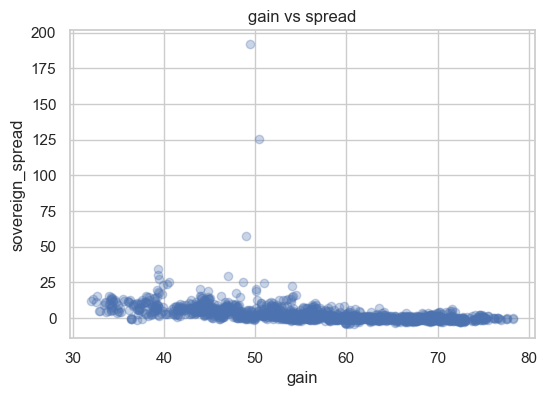

bin
(31.985, 37.133]    8.528894
(37.133, 42.281]    8.537515
(42.281, 47.429]    6.401155
(47.429, 52.576]    6.491366
(52.576, 57.724]    2.212224
(57.724, 62.872]    0.355864
(62.872, 68.02]    -0.312648
(68.02, 73.167]    -0.169486
(73.167, 78.315]   -0.029130
Name: sovereign_spread, dtype: float64


In [115]:
import matplotlib.pyplot as plt
# simple scatter
plt.figure(figsize=(6,4))
plt.scatter(df['gain'], df['sovereign_spread'], alpha=0.3)
plt.xlabel('gain'); plt.ylabel('sovereign_spread'); plt.title('gain vs spread')
plt.show()

# binned average
import numpy as np
df_temp = df.dropna(subset=['gain','sovereign_spread'])
bins = np.linspace(df_temp['gain'].min(), df_temp['gain'].max(), 10)
df_temp['bin'] = pd.cut(df_temp['gain'], bins)
print(df_temp.groupby('bin')['sovereign_spread'].mean())

In [116]:
    # 1) create lags/leads
df['gain_lag1'] = df.groupby('iso3c')['gain'].shift(1)
df['gain_lag2'] = df.groupby('iso3c')['gain'].shift(2)
df['gain_lag3'] = df.groupby('iso3c')['gain'].shift(3)
# leads (placebo)
df['gain_lead1'] = df.groupby('iso3c')['gain'].shift(-1)
df['gain_lead2'] = df.groupby('iso3c')['gain'].shift(-2)

# If you prefer vulnerability variable (higher = worse), create it:
# df['vulnerability'] = 100.0 - df['gain']   # only if you want to invert 'gain'
# df['vulnerability_lag1'] = df.groupby('iso3c')['vulnerability'].shift(1)

# 2) baseline: pooled lag1 (use 'gain_lag1' or 'vulnerability_lag1')
tcol = 'gain_lag1'
df_run = df.dropna(subset=[tcol, Y_col]).reset_index(drop=True)
out_pooled_lag1 = run_dml_loyo(df_run, covariates_to_use, idcol='iso3c', timecol='year',
                               ycol=Y_col, tcol=tcol, n_trees=200, random_seed=2025)
print("Pooled lag1:", out_pooled_lag1['theta'], float(out_pooled_lag1['res'].bse[0]), float(out_pooled_lag1['res'].pvalues[0]))

# 3) pooled + Bulgaria event control
covs_plus = covariates_to_use + ['bgr_hist_event','extreme_change_flag']
# optionally add interaction term (vul_lag1_bgr) if used in your pipeline
df_run['gain_lag1_bgr'] = df_run['gain_lag1'] * df_run.get('bgr_hist_event', 0)
covs_plus.append('gain_lag1_bgr')

out_pooled_lag1_event = run_dml_loyo(df_run, covs_plus, idcol='iso3c', timecol='year',
                                     ycol=Y_col, tcol=tcol, n_trees=200, random_seed=2025)
print("Pooled lag1 + BGR event:", out_pooled_lag1_event['theta'],
      float(out_pooled_lag1_event['res'].bse[0]), float(out_pooled_lag1_event['res'].pvalues[0]))

# 4) pooled excluding BGR event years
df_no_bgr = df[~((df['iso3c']=='BGR') & (df.get('bgr_hist_event',0)==1))].copy()
df_run2 = df_no_bgr.dropna(subset=[tcol, Y_col]).reset_index(drop=True)
out_pooled_lag1_no_bgr = run_dml_loyo(df_run2, covariates_to_use, idcol='iso3c', timecol='year',
                                      ycol=Y_col, tcol=tcol, n_trees=200, random_seed=2025)
print("Pooled lag1 excluding BGR event years:", out_pooled_lag1_no_bgr['theta'],
      float(out_pooled_lag1_no_bgr['res'].bse[0]), float(out_pooled_lag1_no_bgr['res'].pvalues[0]))

LOYO DML done in 12.9s; theta=0.460759; stacked rows=1468; folds used=28
Pooled lag1: 0.4607589973175241 0.33710072376720807 0.1716789551307546
LOYO DML done in 14.5s; theta=0.298408; stacked rows=1468; folds used=28
Pooled lag1 + BGR event: 0.2984084833464504 0.11507961159030124 0.009512582311993395
LOYO DML done in 12.9s; theta=0.0518418; stacked rows=1466; folds used=28
Pooled lag1 excluding BGR event years: 0.05184184380145649 0.019300253891159785 0.0072297818939481995


In [117]:
# correlations
print("corr gain vs gdp_pc:", df[['gain','gdp_per_capita']].dropna().corr().iloc[0,1])
print("corr gain vs wgi_ge:", df[['gain','wgi_ge']].dropna().corr().iloc[0,1])
print("corr gdp_pc vs spread:", df[['gdp_per_capita','sovereign_spread']].dropna().corr().iloc[0,1])
# partial correlation (gain vs spread controlling for gdp_pc and wgi_ge)
import statsmodels.api as sm
ctrls = df[['gdp_per_capita','wgi_ge']].apply(pd.to_numeric, errors='coerce')
tmp = df[['gain','sovereign_spread']].join(ctrls).dropna()
res1 = sm.OLS(tmp['gain'], sm.add_constant(tmp[['gdp_per_capita','wgi_ge']])).fit()
res2 = sm.OLS(tmp['sovereign_spread'], sm.add_constant(tmp[['gdp_per_capita','wgi_ge']])).fit()
gain_resid = res1.resid
spread_resid = res2.resid
import numpy as np
print("partial corr (gain,spread | gdp,wgi):", np.corrcoef(gain_resid, spread_resid)[0,1])

corr gain vs gdp_pc: 0.77914823053717
corr gain vs wgi_ge: 0.8994312552665098
corr gdp_pc vs spread: -0.3443151262774711
partial corr (gain,spread | gdp,wgi): -0.05826558125073728


In [121]:
import statsmodels.api as sm
base = ['gain_lag1'] 
df['wgi_ge_lag1'] = df.groupby('iso3c')['wgi_ge'].shift(1) # or vulnerability_lag1 if you prefer
suspects = ['ln_gdp_per_capita_lag1','wgi_ge_lag1','sovereign_spread_lag1']
for i in range(len(suspects)+1):
    Xcols = base + suspects[:i]
    tmp = df.dropna(subset=Xcols+[Y_col]).copy()
    X = sm.add_constant(tmp[Xcols].apply(pd.to_numeric, errors='coerce'))
    y = tmp[Y_col].astype(float)
    res = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': tmp['iso3c']})
    print("With:", Xcols, " coef gain:", res.params['gain_lag1'], "p:", res.pvalues['gain_lag1'])

With: ['gain_lag1']  coef gain: -0.2817914960531141 p: 3.2395774911278696e-17
With: ['gain_lag1', 'ln_gdp_per_capita_lag1']  coef gain: -0.06480669791982335 p: 0.39078813031819726
With: ['gain_lag1', 'ln_gdp_per_capita_lag1', 'wgi_ge_lag1']  coef gain: 0.04799001792912996 p: 0.37034374475868415
With: ['gain_lag1', 'ln_gdp_per_capita_lag1', 'wgi_ge_lag1', 'sovereign_spread_lag1']  coef gain: -0.006309732542455055 p: 0.706863185519852


In [ ]:
df['wgi_rl_lag1'] = df.groupby('iso3c')['wgi_rl'].shift(1)
# Define covariate sets
core = ['gdp_annual_growth_rate_lag1','ln_gdp_per_capita_lag1','debt_to_gdp_lag1',
        'deficit_to_gdp_lag1','cpi_yoy_lag1','sovereign_spread_lag1',
        'vix','us_10y','brent','wgi_ge_lag1','wgi_rl_lag1']  # baseline core: lagged macros + lagged WGIs

no_gdp = [c for c in core if 'gdp' not in c]   # drop GDP vars
no_wgi = [c for c in core if not c.startswith('wgi_')]
no_lagspread = [c for c in core if c!='sovereign_spread_lag1']

specs = {
    'core': core,
    'no_gdp': no_gdp,
    'no_wgi': no_wgi,
    'no_lagspread': no_lagspread,
    'core_plus_suspects': core + ['credit_rating_lag1']  # example of adding potential mediators 
}

results = {}
for name, covs in specs.items():
    df_run = df.dropna(subset=['gain_lag1', Y_col]).reset_index(drop=True)
    out = run_dml_loyo(df_run, covs, idcol='iso3c', timecol='year', ycol=Y_col, tcol='gain_lag1',
                       n_trees=200, random_seed=2025)
    results[name] = (out['theta'], float(out['res'].bse[0]), float(out['res'].pvalues[0]))
    print(name, results[name])

LOYO DML done in 9.9s; theta=0.439669; stacked rows=1468; folds used=28
core (0.4396687897124389, 0.2443512718432048, 0.0719663556648683)
LOYO DML done in 7.3s; theta=0.335524; stacked rows=1468; folds used=28
no_gdp (0.335523648268108, 0.21410394246614928, 0.11708983467508763)
LOYO DML done in 8.6s; theta=0.36641; stacked rows=1468; folds used=28
no_wgi (0.3664095205938563, 0.1745974605206101, 0.03585253516844122)
LOYO DML done in 9.3s; theta=0.231969; stacked rows=1468; folds used=28
no_lagspread (0.23196936589831618, 0.20901900637942103, 0.2670850695723538)
LOYO DML done in 10.8s; theta=0.439669; stacked rows=1468; folds used=28
core_plus_suspects (0.43966878971243883, 0.24435127184320468, 0.07196635566486823)
